# Ejercicio 3

### 1. Lectura y representación de la serie. Descomposición. Conclusiones.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

defun = pd.read_excel('defunciones.xlsx')

defun

Todas las causas  Tumores  Causas externas
0        1980M01             28681     4883             1277
1        1980M02             23906     4493             1122
2        1980M03             25275     4957             1244
3        1980M04             22500     4523             1214
4        1980M05             22781     4893             1228
..           ...               ...      ...              ...
463      2018M08             33177     9370             1472
464      2018M09             30293     9079             1306
465      2018M10             32879     9629             1275
466      2018M11             34338     9315             1234
467      2018M12             37033     9743             1268

[468 rows x 4 columns]

In [2]:
defun.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0                     468 non-null    object
 1   Todas las causas  468 non-null    int64 
 2   Tumores           468 non-null    int64 
 3   Causas externas   468 non-null    int64 
dtypes: int64(3), object(1)
memory usage: 14.8+ KB


Vemos que la información de fechas viene de forma mensual, desde 1980 hasta el 2018, sin embargo tiene un formato no reconocido por python, por lo que vamos a generar correctamente la variable fecha para cada periodo

In [3]:
dates = pd.date_range(start='1980', periods=defun.shape[0], freq='M')
dates

DatetimeIndex(['1980-01-31', '1980-02-29', '1980-03-31', '1980-04-30',
               '1980-05-31', '1980-06-30', '1980-07-31', '1980-08-31',
               '1980-09-30', '1980-10-31',
               ...
               '2018-03-31', '2018-04-30', '2018-05-31', '2018-06-30',
               '2018-07-31', '2018-08-31', '2018-09-30', '2018-10-31',
               '2018-11-30', '2018-12-31'],
              dtype='datetime64[ns]', length=468, freq='M')

In [4]:
defun.set_index(dates, inplace = True)
defun = defun.drop([' '],axis=1)
defun

Todas las causas  Tumores  Causas externas
1980-01-31             28681     4883             1277
1980-02-29             23906     4493             1122
1980-03-31             25275     4957             1244
1980-04-30             22500     4523             1214
1980-05-31             22781     4893             1228
...                      ...      ...              ...
2018-08-31             33177     9370             1472
2018-09-30             30293     9079             1306
2018-10-31             32879     9629             1275
2018-11-30             34338     9315             1234
2018-12-31             37033     9743             1268

[468 rows x 3 columns]

Ya tenemos la serie lista, con el formato correcto, vemos además que no hay missing data, vamos a hacer un poco más de anális gráfico para entenderla mejor

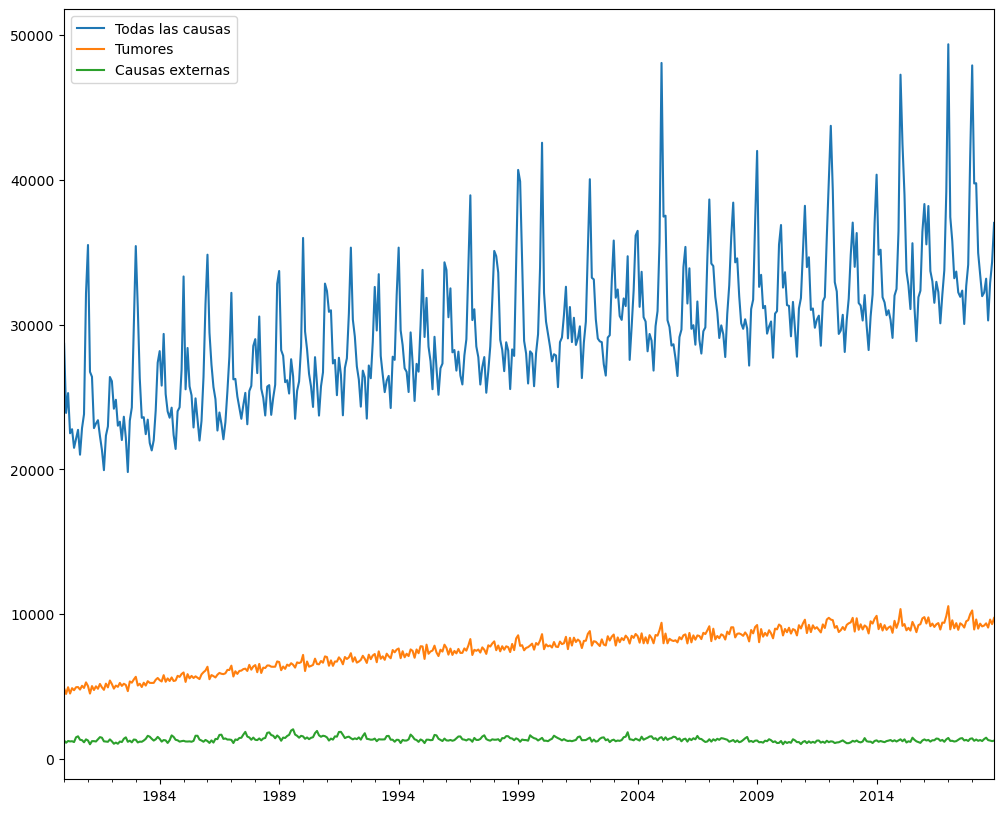

In [5]:
plt.rcParams["figure.figsize"] = (12,10)
defun.plot()
plt.show()

Enfoquémonos en las muertes por todas las causas:

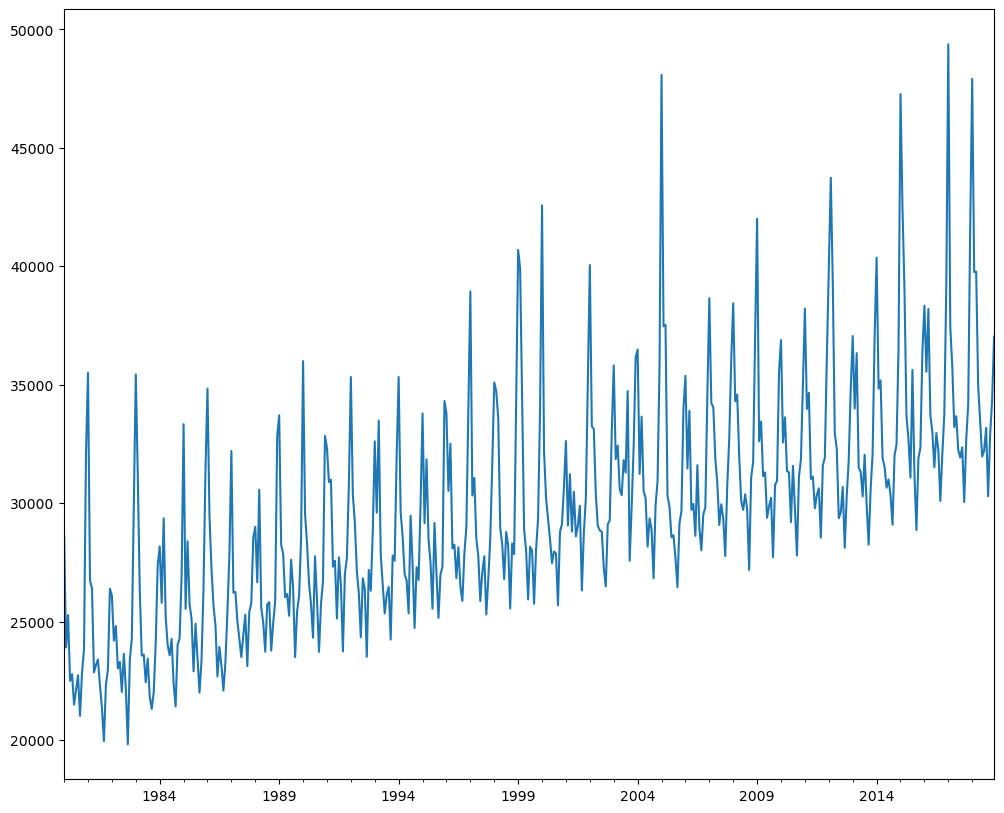

In [6]:
plt.rcParams["figure.figsize"] = (12,10)
defun['Todas las causas'].plot()
plt.show()

A simple vista podemos intuir que la serie no es estacionaria puesto que tiene una tendencia claramente positiva, de todas formas haremos el test de Dickey Fuller para probar la no estacionariedad de la serie:

Para esta prueba tenemos:
- H0: La serie NO es estacionaria 
- H1: La serie es estacionaria

In [7]:
from statsmodels.tsa.stattools import adfuller

def test_DF(data):
    print('Results of Dickey-Fuller Test for:')
    dftest = adfuller(data, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_DF(defun['Todas las causas'])

Results of Dickey-Fuller Test for:
Test Statistic                  -0.942604
p-value                          0.773619
#Lags Used                      14.000000
Number of Observations Used    453.000000
Critical Value (1%)             -3.444868
Critical Value (5%)             -2.867941
Critical Value (10%)            -2.570180
dtype: float64


En efecto, vemos que la serie no es estacionaria. 

Veamos ahora el gráfico de estacionalidad para determinar si hay oscilaciones periódicas (que a simple vista parece haberlas):

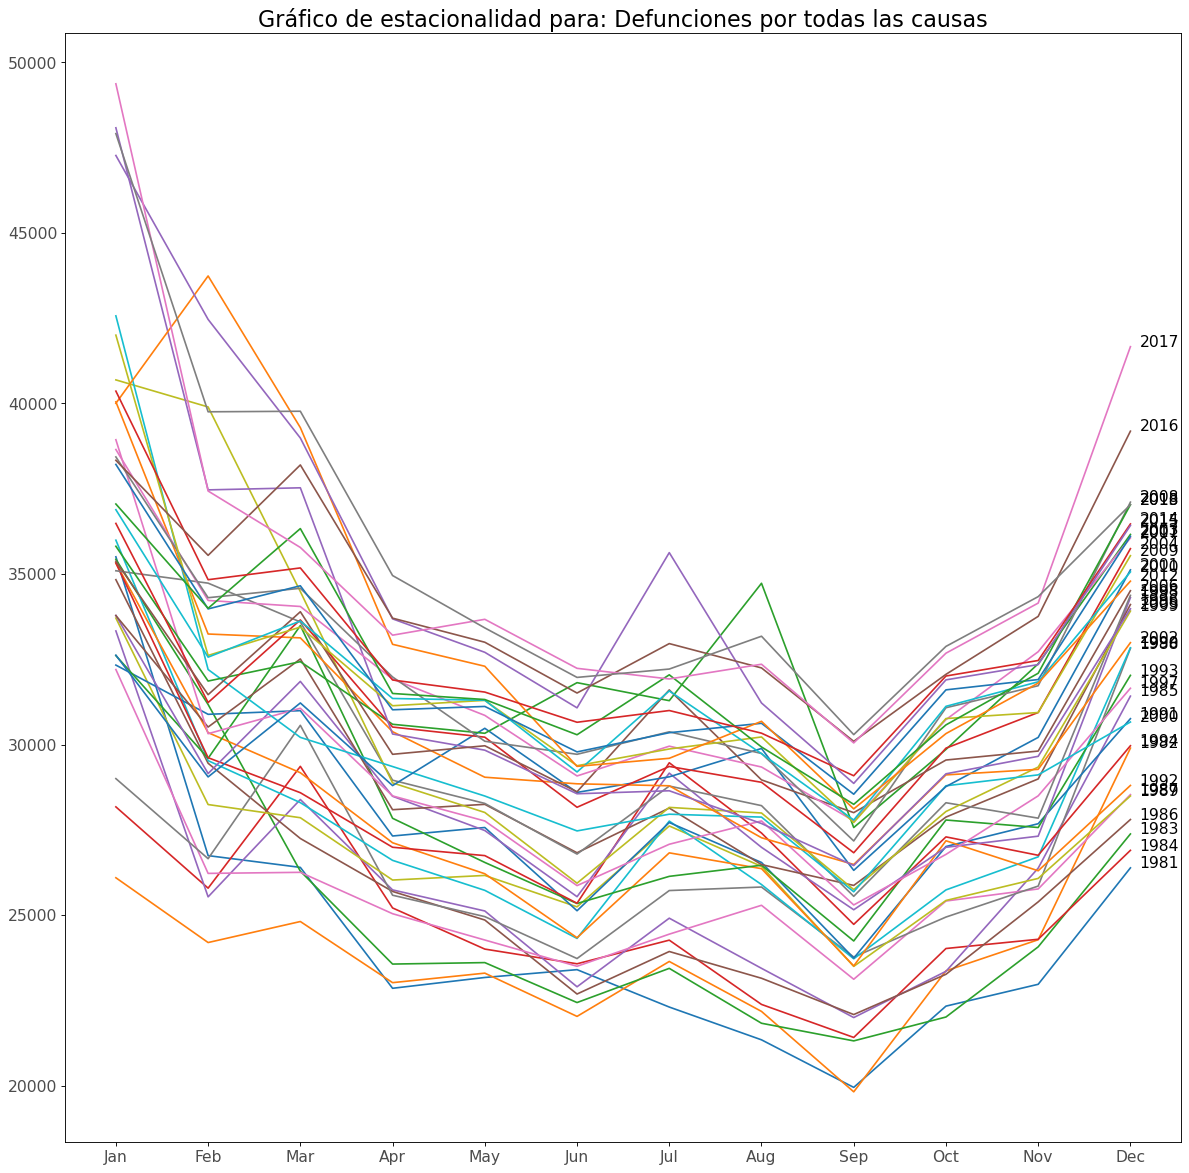

In [8]:
defun['year'] = [d.year for d in defun.index]
defun['month'] = [d.strftime('%b') for d in defun.index]
years = defun['year'].unique()

plt.figure(figsize=(18,18), dpi= 80)
for i, y in enumerate(years):
    if i > 0:        
        plt.plot('month', 'Todas las causas', data=defun.loc[defun.year==y, :], label=y)
        plt.text(defun.loc[defun.year==y, :].shape[0]-.9, defun.loc[defun.year==y, 'Todas las causas'][-1:].values[0], y, fontsize=14)

plt.yticks(fontsize=14, alpha=.7)
plt.xticks(fontsize=14, alpha=.7)
plt.title("Gráfico de estacionalidad para: Defunciones por todas las causas", fontsize=20)
plt.show()

Es cierto que vemos un comportamiento oscilatorio con las mismas tendencias año con año por lo que hay estacionalidad en periodos de un año.

Vamos a hacer ahora la descomposición de la serie, primero la descomposición aditiva (que en este caso parece la más apropiada puesto que las fluctuaciones no parecen variar con la tendencia, no tenemos heterocedasticidad) y luego probaremos también la descomposición multiplicativa. 

##### Descomposición aditiva

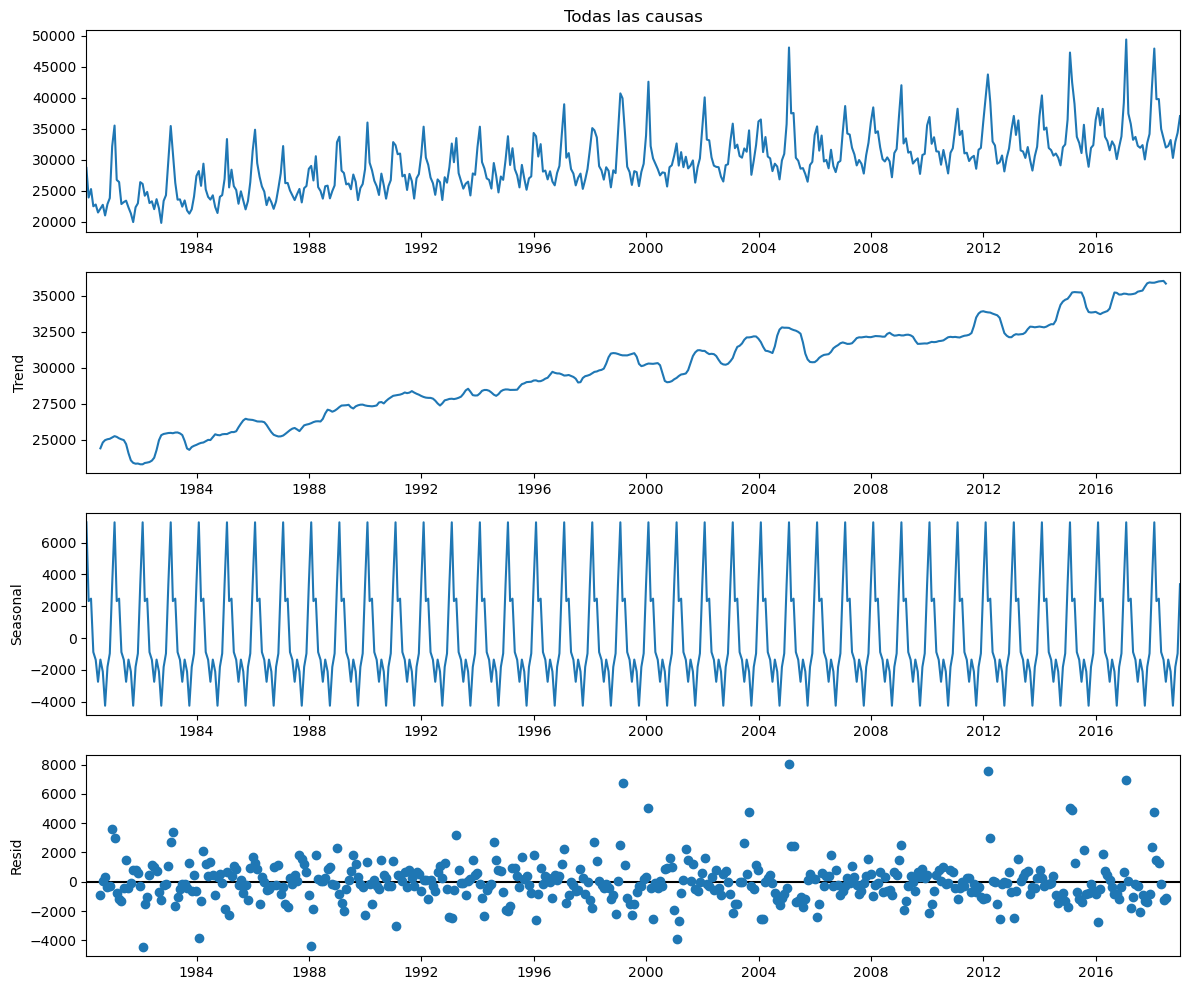

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose

defun_desc_Ad = seasonal_decompose(defun['Todas las causas'], model='additive',period=12)
defun_desc_Ad.plot()
plt.show()

In [10]:
test_DF(defun_desc_Ad.resid.dropna())

Results of Dickey-Fuller Test for:
Test Statistic                -9.833132e+00
p-value                        4.975783e-17
#Lags Used                     1.800000e+01
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


##### Descomposición multiplicativa

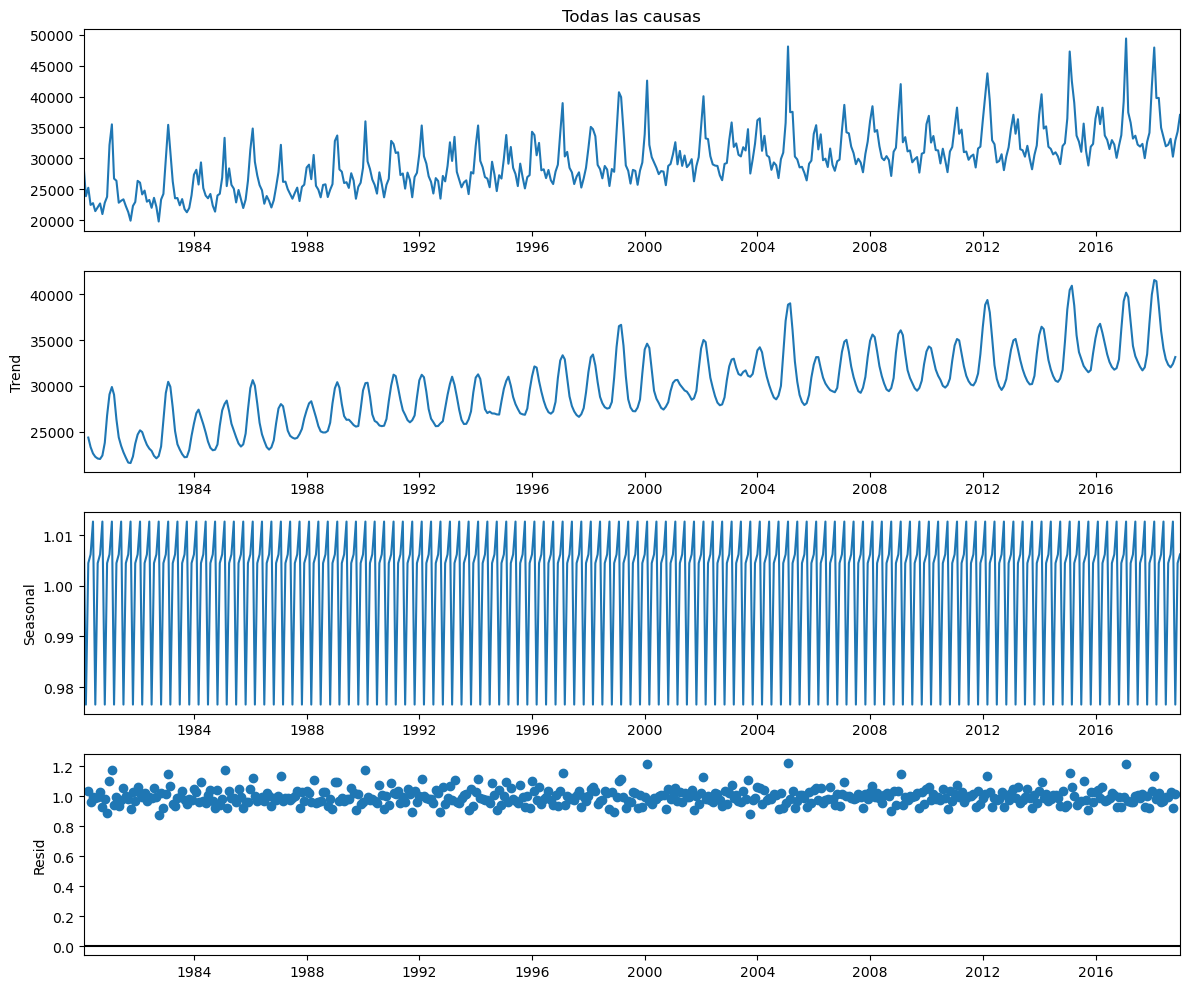

In [11]:
defun_desc_Mul = seasonal_decompose(defun['Todas las causas'], model='multiplicative',period=4)
defun_desc_Mul.plot()
plt.show()

In [12]:
test_DF(defun_desc_Mul.resid.dropna())

Results of Dickey-Fuller Test for:
Test Statistic                -6.649647e+00
p-value                        5.159500e-09
#Lags Used                     1.800000e+01
Number of Observations Used    4.450000e+02
Critical Value (1%)           -3.445131e+00
Critical Value (5%)           -2.868057e+00
Critical Value (10%)          -2.570241e+00
dtype: float64


En ambos casos logramos tener residuos que pasan el test de Dickey Fuller

##### Camino a la estacionariedad

Vamos a hacer algunas transformaciones a la serie para buscar que sea estacional, para esto nos dejamos influir por las observaciones anteriores, tambien por el hecho de que no parece haber heterocedasticidad en esta serie, o de haberla sería mínima entonces entonces no hay necesidad de estabilizar la varianza, pero si debemos eliminar la tendencia y la estacionalidad mediante una diferenciación regular y una diferenciación estacional respectivamente; veamos:

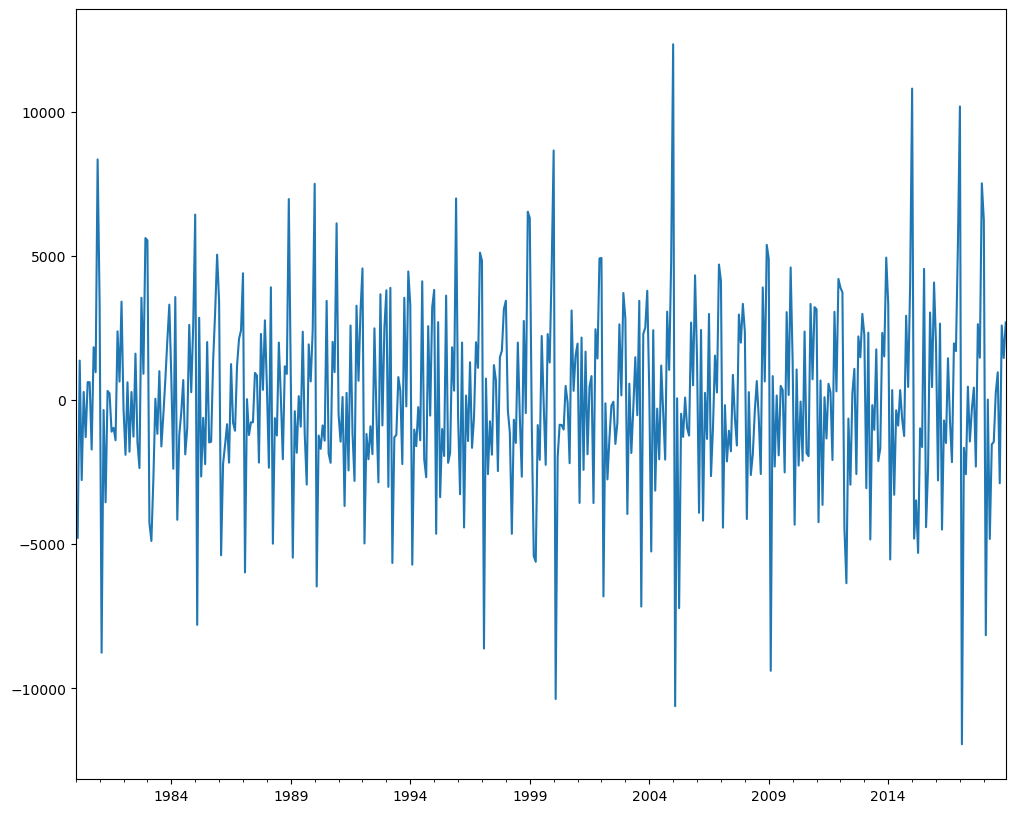

In [13]:
#Diferenciación regular:

defun_diff = defun['Todas las causas'].diff(periods=1)
defun_diff.plot()
plt.show()

In [14]:
#Comprobación de estacionariedad:

test_DF(defun_diff.dropna())

Results of Dickey-Fuller Test for:
Test Statistic                -9.285078e+00
p-value                        1.221626e-15
#Lags Used                     1.300000e+01
Number of Observations Used    4.530000e+02
Critical Value (1%)           -3.444868e+00
Critical Value (5%)           -2.867941e+00
Critical Value (10%)          -2.570180e+00
dtype: float64


Aunque tengamos una serie claramente estacional, hemos logrado conseguir la estacionariedad con solo una diferenciación regular, sin embargo haremos también la diferenciación estacional para ver el comportamiento y más adelante analizaremos ambos correlogramas para ver si en efecto la diferenciación regular es suficiente o si preferimos la serie doblemente diferenciada.

In [15]:
# Diferenciación Estacional

defun_diff_2 = defun_diff.diff(periods=12)
defun_diff_2.plot()
plt.show()

In [16]:
# Comprobación de estacionariedad

test_DF(defun_diff_2.dropna())

Results of Dickey-Fuller Test for:
Test Statistic                -1.024532e+01
p-value                        4.633996e-18
#Lags Used                     1.700000e+01
Number of Observations Used    4.370000e+02
Critical Value (1%)           -3.445403e+00
Critical Value (5%)           -2.868177e+00
Critical Value (10%)          -2.570305e+00
dtype: float64


Con la diferenciación estacional, hemos reducido (aún más) el valor del p-value, sin embargo aún debemos evaluar las autodcoleraciones para las series luego de ambas diferenciaciones para ver si es suficiente o no

##### Conclusiones

- De acuerdo con la representación gráfica de la serie y posteriormente con el test de Dickey Fuller, podemos confirmar que la serie de datos de defunciones por todas las causas entre 1980 y 2018 no es estacionaria, sino que su media va aumentando a lo largo del tiempo.
- En el gráfico estacional, además vemos que todos los fin y principio de año tienen un aumento en las defunciones, sobretodo a inicio de año, luego la cifra va cayendo hasta llegar a los valores más bajos alrededor de setiembre y luego tiende a aumentar
- Se realizó la descomposición de la serie, extrayendo los componentes de tendencia y estacionalidad y luego se midió la estacionariedad de los residuos, obteniendo que estos si tienen un comportamiento estacionario como era de esperarse.
- Con la diferenciación regular y luego una diferenciación estacional, hemos conseguido convertir la serie en una serie estacionaria, lo cual nos será de utilidad posteriormente cuando trabajemos modelos ARIMA.


### 2. Partición training y test (los últimos 2 años de datos).

Vamos a generar la partición de training y test, usando para test los ultimos 2 años de datos; vamos a utilizar la serie al natural considerando que no hay componente de Heterocedasticidad, sin embargo en caso de ser necesario (según veamos los resultados, luego haríamos una transformación logarítmica y estudiamos ambos modelos:

In [17]:
import statsmodels.tsa.holtwinters as ets
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

defun_1 = defun['Todas las causas']

defun_tr = defun_1[:'2016-12-31']
defun_tst = defun_1['2017-01-01':]
defun_tst

2017-01-31    49370
2017-02-28    37434
2017-03-31    35779
2017-04-30    33208
2017-05-31    33673
2017-06-30    32236
2017-07-31    31924
2017-08-31    32356
2017-09-30    30049
2017-10-31    32680
2017-11-30    34149
2017-12-31    41665
2018-01-31    47911
2018-02-28    39756
2018-03-31    39772
2018-04-30    34956
2018-05-31    33421
2018-06-30    31970
2018-07-31    32215
2018-08-31    33177
2018-09-30    30293
2018-10-31    32879
2018-11-30    34338
2018-12-31    37033
Freq: M, Name: Todas las causas, dtype: int64

### 3. Mejor modelo de suavizado exponencial. ¿Pasa el test residual de Ljung.Box?

Para el caso de esta serie, pareciera que el modelo ideal sería el Suavizado de Holt Winters aditivo, esto porque presenta tendencia y estacionalidad que no varía mucho a lo largo del tiempo; no vemos heterocedasticidad, pero de todas formas vamos a probar también el suavizado de Holt Winters multiplicativo para comparar los dos modelos. 

Vamos a crear primero la función que se usaría para evaluar los modelos y luego generamos los modelos para ir probandolos:

In [18]:
def eval_model(model,tr,tst,name='Model',lags=12):
    lb = np.mean(sm.stats.acorr_ljungbox(model.resid, lags=lags, return_df=True).lb_pvalue)
    pred = model.forecast(steps=len(tst))
    fig1, ax = plt.subplots()
    ax.plot(tr, label='Training')
    ax.plot(tst, label='Test')
    ax.plot(pred, label='Prediction')
    plt.legend(loc='upper left')
    tit = name + ":  LjungBox p-value --> " + str(lb) + "\n MAPE: " + str(round(mean_absolute_percentage_error(tst, pred)*100,2)) + "%"
    plt.title(tit)
    plt.ylabel('Defunciones')
    plt.xlabel('Date')
    plt.show()
    print(lb)

##### Suavizado Holt Winters aditivo:

In [19]:
hw_add = ets.ExponentialSmoothing(defun_tr,trend='add', damped_trend=False, seasonal='add').fit()
hw_add.summary()

C:\Users\ferli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:         Todas las causas   No. Observations:                  444
Model:             ExponentialSmoothing   SSE                     1145515912.319
Optimized:                         True   AIC                           6586.904
Trend:                         Additive   BIC                           6652.437
Seasonal:                      Additive   AICC                          6588.513
Seasonal Periods:                    12   Date:                 Sun, 19 Feb 2023
Box-Cox:                          False   Time:                         12:19:41
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4646429                alpha                 True
smoothing_trend                  0.0001                 beta                 True
smoothing_seasonal            0.0509864                gamma                 True
initial_level                 24676.150                  l.0                 True
initial_trend                 57.749242                  b.0                 True
initial_seasons.0             6578.4436                  s.0                 True
initial_seasons.1             2235.6936                  s.1                 True
initial_seasons.2             1974.2248                  s.2                 True
initial_seasons.3            -1094.5981                  s.3                 True
initial_seasons.4            -1253.4939                  s.4                 True
initial_seasons.5            -1863.8793                  s.5                 True
initial_seasons.6            -1579.6085                  s.6                 True
initial_seasons.7            -2447.9835                  s.7                 True
initial_seasons.8            -4005.9627                  s.8                 True
initial_seasons.9            -1961.5460                  s.9                 True
initial_seasons.10           -858.80642                 s.10                 True
initial_seasons.11            4277.5165                 s.11                 True
---------------------------------------------------------------------------------
"""

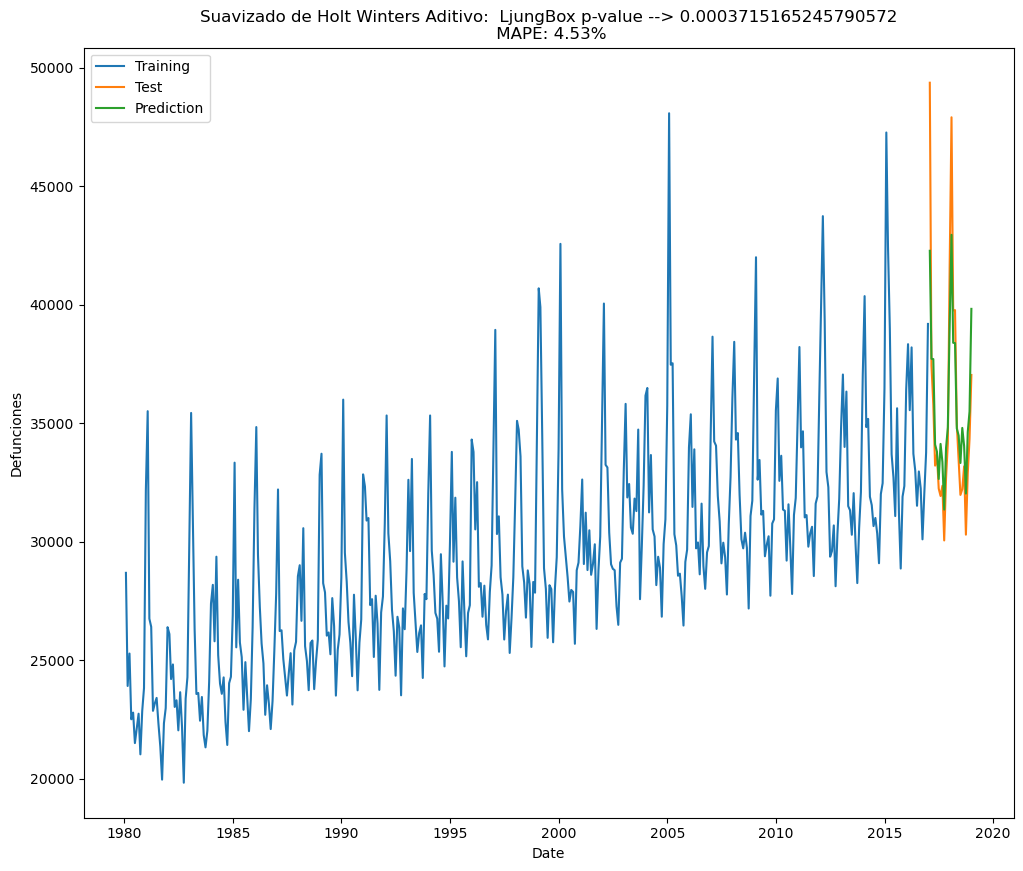

0.0003715165245790572


In [20]:
plt.rcParams["figure.figsize"] = (12,10)
eval_model(hw_add, defun_tr, defun_tst, 'Suavizado de Holt Winters Aditivo')

##### Suavizado de HW Multiplicativo:

In [21]:
hw_mul = ets.ExponentialSmoothing(defun_tr,trend='mul', damped_trend=False, seasonal='mul').fit()
hw_mul.summary()

C:\Users\ferli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:         Todas las causas   No. Observations:                  444
Model:             ExponentialSmoothing   SSE                     1124543562.024
Optimized:                         True   AIC                           6578.699
Trend:                   Multiplicative   BIC                           6644.233
Seasonal:                Multiplicative   AICC                          6580.309
Seasonal Periods:                    12   Date:                 Sun, 19 Feb 2023
Box-Cox:                          False   Time:                         12:19:42
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4646429                alpha                 True
smoothing_trend                  0.0001                 beta                 True
smoothing_seasonal            0.0764796                gamma                 True
initial_level                 24676.150                  l.0                 True
initial_trend                 1.0023403                  b.0                 True
initial_seasons.0             1.2629471                  s.0                 True
initial_seasons.1             1.0893550                  s.1                 True
initial_seasons.2             1.0804880                  s.2                 True
initial_seasons.3             0.9569062                  s.3                 True
initial_seasons.4             0.9505575                  s.4                 True
initial_seasons.5             0.9253259                  s.5                 True
initial_seasons.6             0.9359126                  s.6                 True
initial_seasons.7             0.9005029                  s.7                 True
initial_seasons.8             0.8378537                  s.8                 True
initial_seasons.9             0.9212502                  s.9                 True
initial_seasons.10            0.9660699                 s.10                 True
initial_seasons.11            1.1728310                 s.11                 True
---------------------------------------------------------------------------------
"""

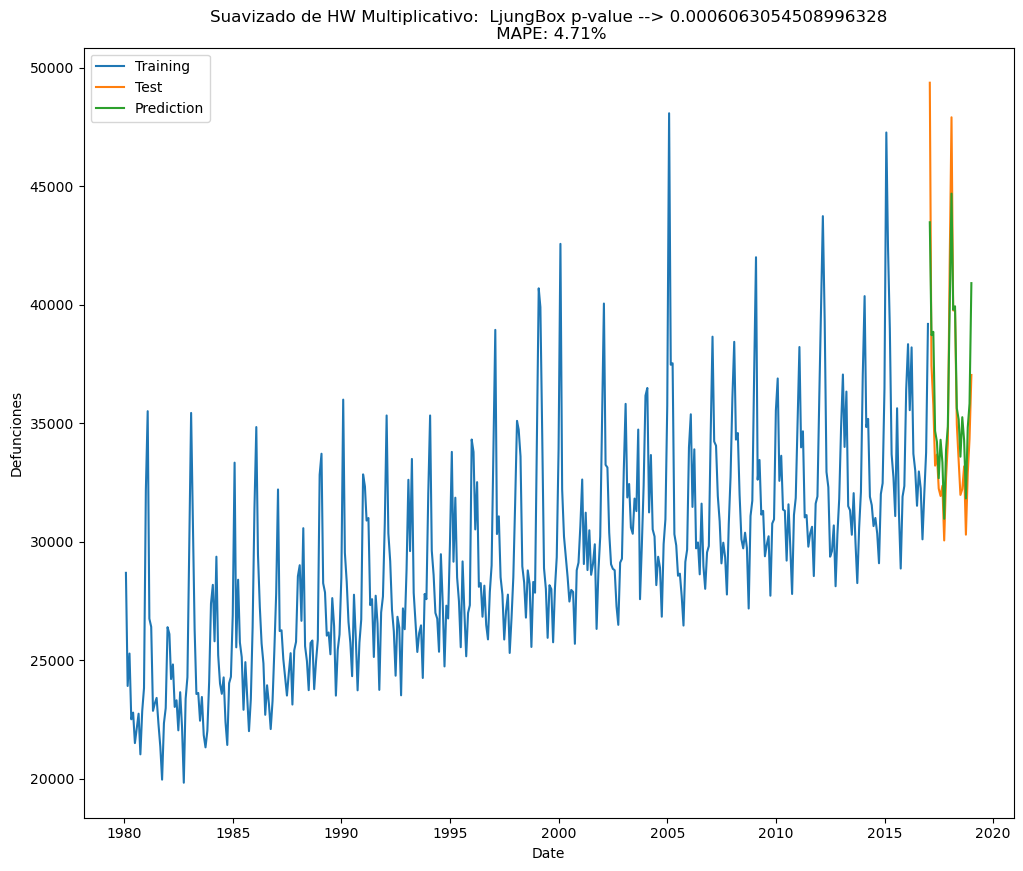

0.0006063054508996328


In [22]:
plt.rcParams["figure.figsize"] = (12,10)
eval_model(hw_mul, defun_tr, defun_tst, 'Suavizado de HW Multiplicativo')

Los dos modelos con suavizado de Holt Winters se ajustan relativamente bien, con errores medios de 4.53% y 4.71%, sin embargo el p-value el Ljung-Box test es muy bajo en ambos casos por lo que estaríamos rechazando la hipótesis nula de que los residuos no tengan autocorrelación. 

Vamos a probar nuevamente estos modelos, pero usando la serie logarítmica (pensando en que quizás si haya un componente de heterocedasticidad) para ver si encontramos mejores resultados en cuanto a error medio y que además pasen el test residual de Ljung-Box.

Generamos la partición de los datos transformados logarítmicamente:

In [23]:
defun_log = defun.copy()
defun_log_2 = np.log(defun_log['Todas las causas'])

defun_tr1 = defun_log_2[:'2016-12-31']
defun_tst1 = defun_log_2['2017-01-01':]

##### Suavizado de Holt Winters aditivo para la serie transformada

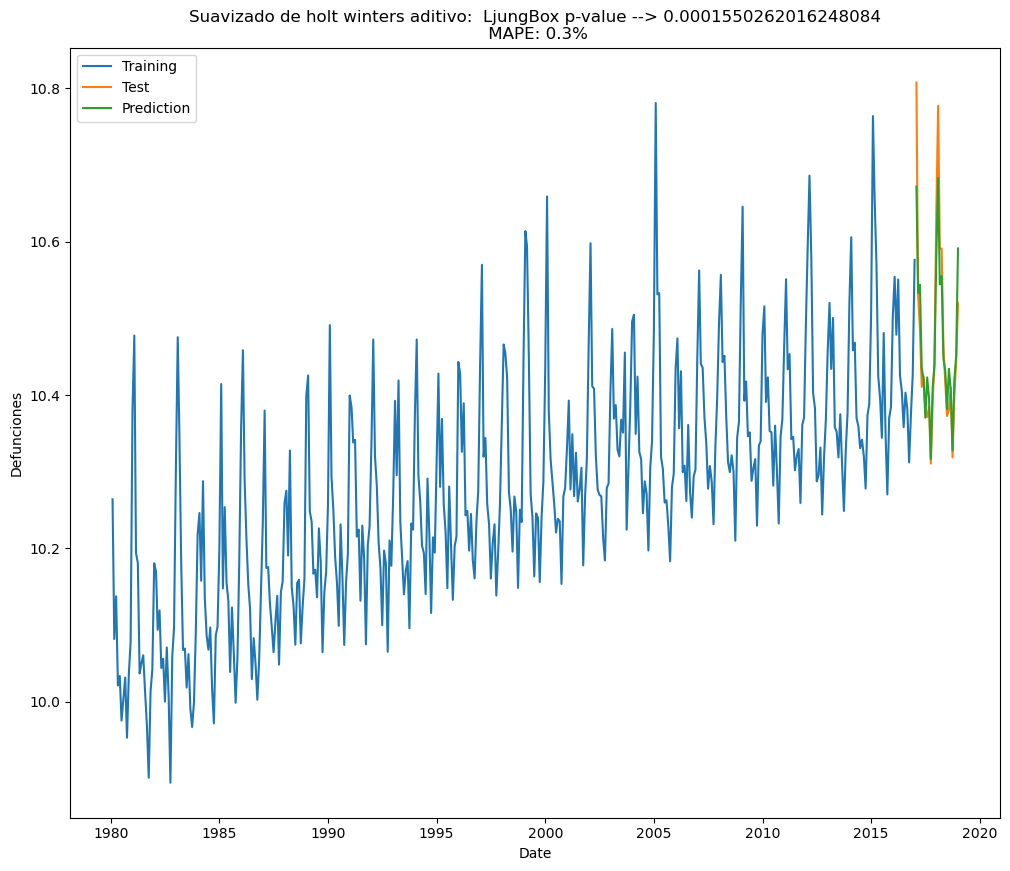

0.0001550262016248084


In [24]:
hw_add1 = ets.ExponentialSmoothing(defun_tr1,trend='add', damped_trend=False, seasonal='add').fit()
hw_add1.summary()

eval_model(hw_add1, defun_tr1, defun_tst1, 'Suavizado de holt winters aditivo')

##### Suavizado de Holt Winters Multiplicativo para la serie transformada

C:\Users\ferli\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


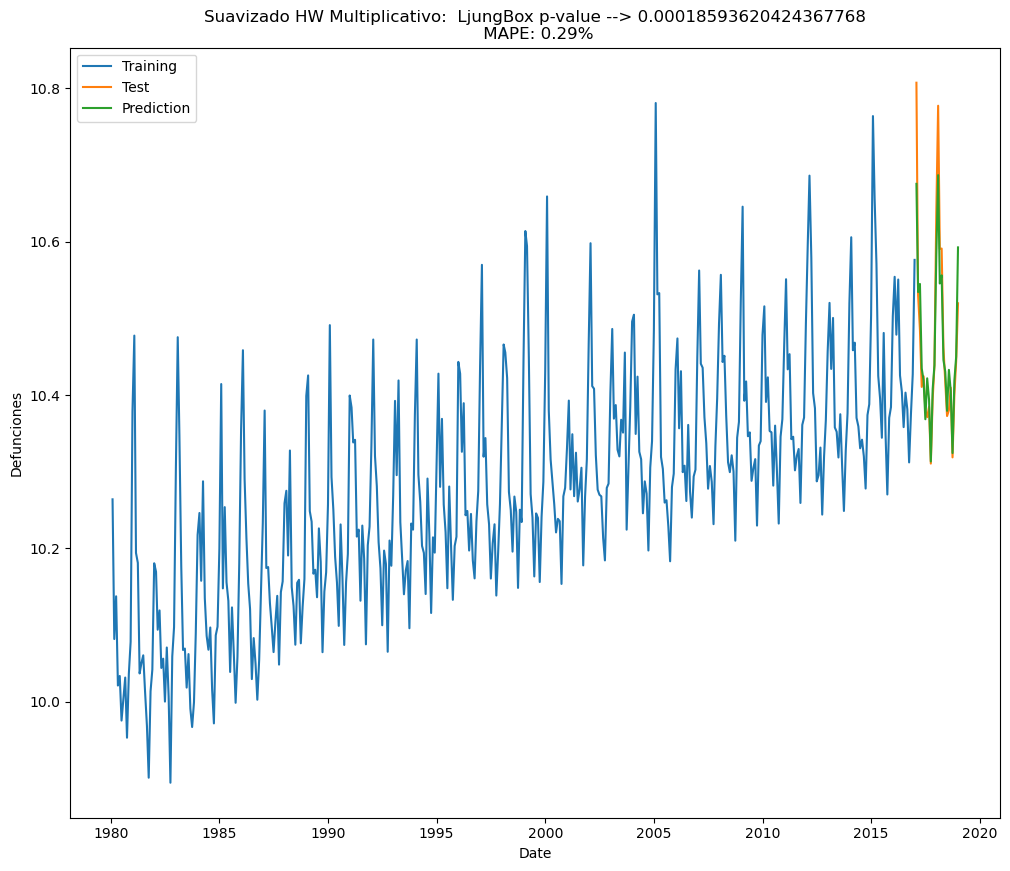

0.00018593620424367768


In [25]:
hw_mul1 = ets.ExponentialSmoothing(defun_tr1,trend='mul', damped_trend=False, seasonal='mul').fit()

eval_model(hw_mul1, defun_tr1, defun_tst1, 'Suavizado HW Multiplicativo')

Trabajando la serie transformada logarítmicamente solo hemos conseguido mejorar (mucho) el error medio, sin embargo los resultados del test de Ljung-Box son prácticamente iguales o incluso ligeramente peores. 

Veamos los correlogramas de los residuos para los modelos creados con la transformación logarítmica que es la que nos da mejores resultados hasta ahora:

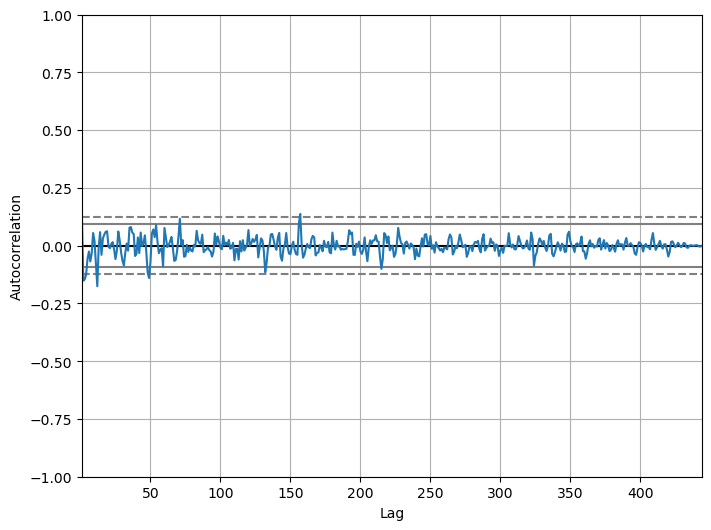

In [26]:
from pandas.plotting import autocorrelation_plot

#Para el modelo aditivo:
plt.rcParams["figure.figsize"] = (8,6)
plt.clf()
autocorrelation_plot(hw_add.resid)
plt.show()


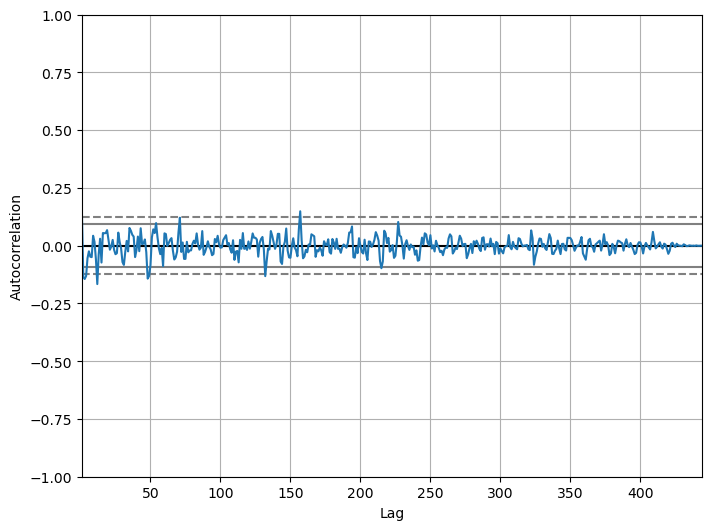

In [27]:
#Para el modelo multiplicativo:

plt.clf()
autocorrelation_plot(hw_mul1.resid)
plt.show()

Pareciera que los residuos son muy muy similares con y sin transformación logarítmica. 

Si nos basamos en los resultados de MAPE, tenemos que el mejor modelo es el de Holt Winter multiplicativo; sin embargo recordemos una vez más que no estamos teniendo el resultado deseado en el test de Ljung-Box por lo tanto aún no tenemos un buen modelo. Vamos a estudiar los modelos ARIMA para ver si los resultados son más alentadores.

##### 4. Mejor modelo ARIMA. ¿Pasa el test residual de Ljung.Box?

Definimos las funciones para evaluar los modelos:

In [28]:
import scipy.stats as stats
import seaborn as sns

# Evaluar residuos mediante pruebas de hipótesis:

def residcheck(residuals, lags):
    resid_mean = np.mean(residuals)
    lj_p_val = np.mean(sm.stats.acorr_ljungbox(x=residuals, lags=lags).lb_pvalue)
    norm_p_val =  stats.jarque_bera(residuals)[1]
    adfuller_p = adfuller(residuals)[1]
        
      
    fig = plt.figure(figsize=(10,8))
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2);
    acf_ax = plt.subplot2grid(layout, (1, 0));
    kde_ax = plt.subplot2grid(layout, (1, 1));
    
    residuals.plot(ax=ts_ax)
    plot_acf(residuals, lags=lags, ax=acf_ax);
    sns.kdeplot(residuals);
    #[ax.set_xlim(1.5) for ax in [acf_ax, kde_ax]]
    sns.despine()
    plt.tight_layout();
    plt.show()
    print("** Mean of the residuals: ", np.around(resid_mean,2))
        
    print("\n** Ljung Box Test, p-value:", np.around(lj_p_val,3), 
        "(>0.05, Uncorrelated)" if (lj_p_val > 0.05) else "(<0.05, Correlated)")
        
    print("\n** Jarque Bera Normality Test, p_value:", np.around(norm_p_val,3),
        "(>0.05, Normal)" if (norm_p_val>0.05) else "(<0.05, Not-normal)")
        
    print("\n** AD Fuller, p_value:", np.around(adfuller_p,3), 
        "(>0.05, Non-stationary)" if (adfuller_p > 0.05) else "(<0.05, Stationary)")
    
    return ts_ax, acf_ax, kde_ax   

In [29]:
# Evaluar modelo auto-arima:

def eval_model_Aarima(model,tr,tst,name='Model',lags=12):
      lb = np.mean(sm.stats.acorr_ljungbox(model.resid(), lags=lags, return_df=True).lb_pvalue)
      pred = model.predict(n_periods=len(tst))
      fig1, ax = plt.subplots()
      ax.plot(tr, label='training')
      ax.plot(tst, label='test')
      ax.plot(pred, label='prediction')
      plt.legend(loc='upper left')
      tit = name +": LjungBox p-value -> "+str(lb) +"\n MAPE: " +str(round(mean_absolute_percentage_error(tst, pred)*100,2))+"%"
      plt.title(tit)
      plt.ylabel('Serie')
      plt.xlabel('Date')
      plt.show()
      model.plot_diagnostics(figsize=(14,10))
      plt.show()  

### Arima Manual

Anteriormente habíamos generado la serie doblemente diferenciada que nos llevó a la estacionalidad, sin embargo aún debemos evaluar las autodcoleraciones para las series luego de ambas diferenciaciones para evaluarlas (con diferenciación regular la serie pasa el test de Dickey Fuller, pero no sabemos aún que pasa con las autocorrelaciones) y también para para identificar patrones de efectos AR y MA tentativos; a continuación los correlogramas de la serie antes y después de la doble diferenciación:

**Serie al natural:**

In [30]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plt.rcParams["figure.figsize"] = (10,8)

plot_acf(defun['Todas las causas'],lags=48)
plt.show()

**Serie con diferenciación regular:**

In [31]:
plot_acf(defun_diff.dropna(inplace=False),lags=48)
plt.show()

Con diferenciación regular mejora mucho el tema de autocorrelaciones en lo regular, pero como era de esperarse, aun tenemos un fuerte impacto por estacionalidad. 

**Serie doblemente diferenciada:**

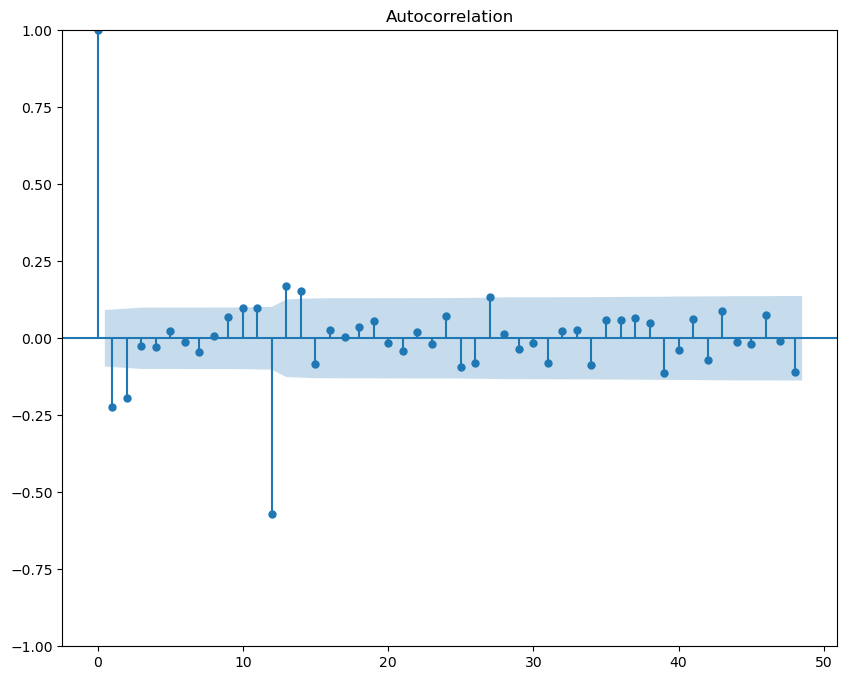

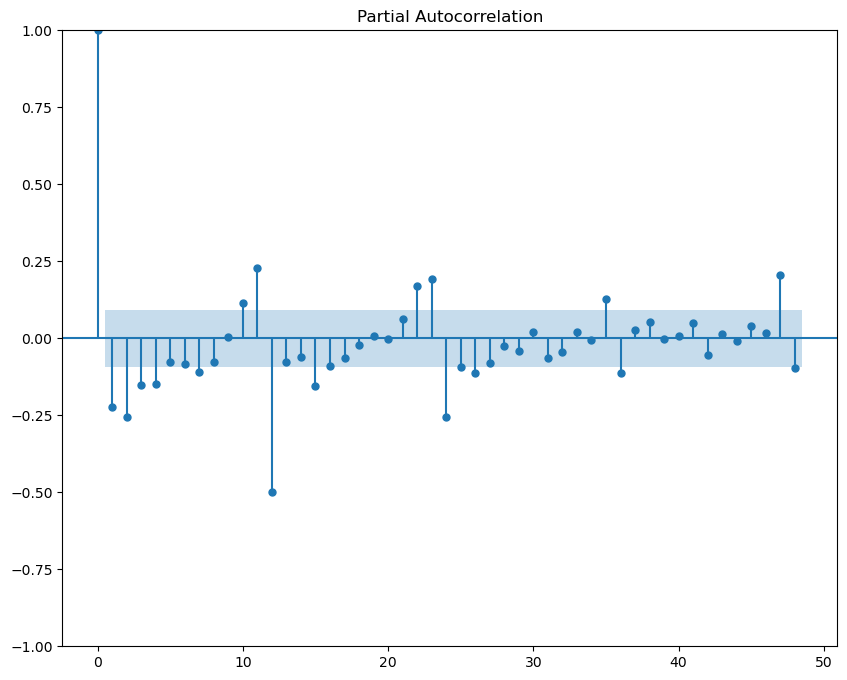

In [32]:
plot_acf(defun_diff_2.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(defun_diff_2.dropna(inplace=False),lags=48,method='ywm')
plt.show()

Como era de esperarse, la serie con diferenciación estacional, nos ayuda a reducir las correlaciones estacionales (observadas cada 12 meses), que tienen valores muy elevados cuando trabajamos con la serie diferenciada regular; por lo que trabajaremos con la doble diferenciación para modelar. Pero antes veamos también los correlogramas para la serie con transformación logarítmica y doblemente diferenciada (considerando que con el suavizado obtuvimos un mejor resultado de MAPE en este caso)

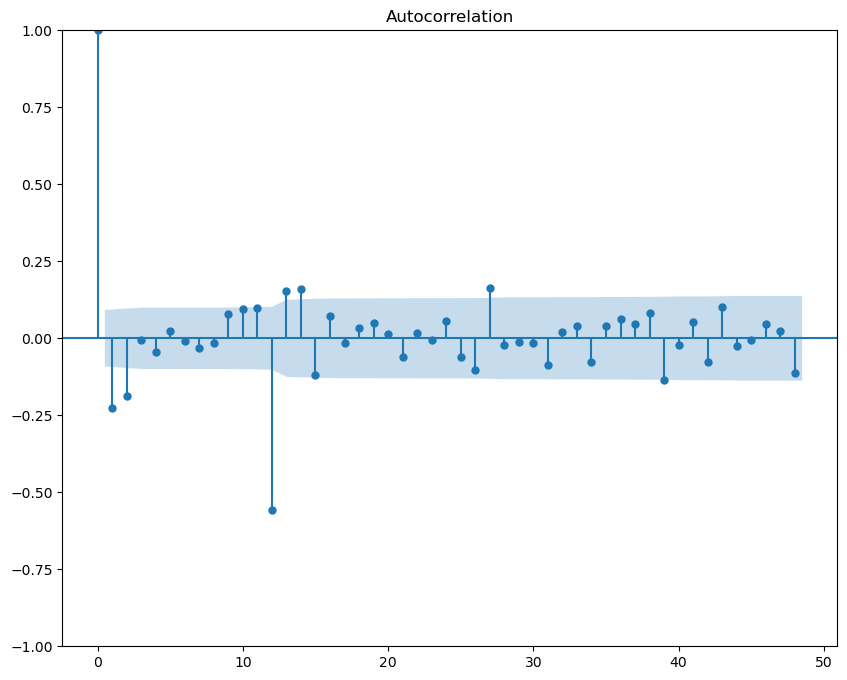

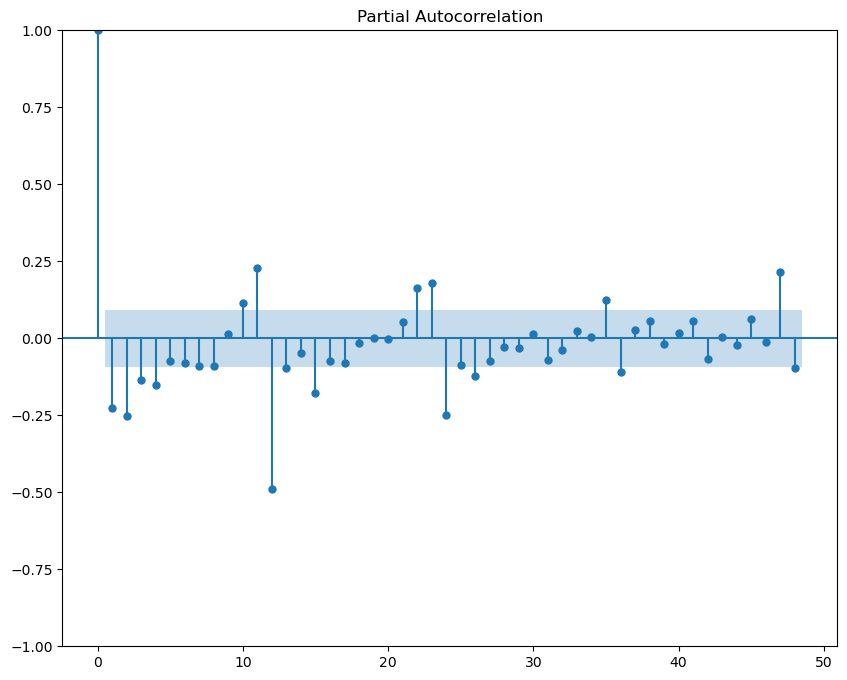

In [33]:
defun_log_diff_2 = np.log(defun['Todas las causas']).diff(periods=1).diff(periods=12)

plot_acf(defun_log_diff_2.dropna(inplace=False),lags=48)
plt.show()
plot_pacf(defun_log_diff_2.dropna(inplace=False),lags=48,method='ywm')
plt.show()

No se ven grandes diferencias, parece que los residuos son muy parecidos con o sin transformación logarítmica. Extraño entonces que haya tanta diferencia en los errores... 

En conclusión, tenemos practicamente lo mismo si transformamos o no la serie, con la única diferencia de que obtenemos un MAPE menor, así que es suficiente para decidir usar esta transformación logarítmica, ningún daño nos hace y solo reduce el error del modelo.

En todo caso, al ser tan similares los residuos, podemos hacer un mismo análisis de los correlogramas y para definir los órdenes de d y D:

- Ya sabemos que nuestro valor de d y D será 1 en ambos casos, puesto que hemos diferenciado en lo regular y en lo estacional.
- **En lo regular:** podría ser un AR si consideramos que hay decrecimiento rápido y no un corte marcado en los primeros dos retardos del **ACF**. Sin embargo, también tenemos un decrecimiento en el **PACF**, aunque un poco irregular, pero definitivamente no se corta en los primeros retardos, en ese caso podría haber una superposición con MA, aunque no está claro por esa irregularidad que se ve en el decrecimiento en el PACF, podría ser que el orden de Q sea mayor a 1.
- **En lo estacional:** el retardo 12 es significativo, sin embargo se corta rápidamente en el **ACF** y decrece en el **PACF**, por lo que es más parecido a un MA1 y no se ve tanto el componente AR. 

Como no estamos 100% seguros del componente MA en lo regular y pensando que podría o no existir y pensando que de existir un orden podría explicar la irregularidad que vemos, tenemos tres opciones de posibles modelos:

- ARIMA(1,1,0)(0,1,1)[12]
- ARIMA(1,1,1)(0,1,1)[12]
- ARIMA(1,1,2)(0,1,1)[12]

##### Modelo 1 -> Con AR en lo regular y MA en lo estacional:

In [34]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
  
arima1 = SARIMAX(defun_tr1, 
                order = (1, 1, 0), 
                seasonal_order =(0, 1, 1, 12))
  
arima_1 = arima1.fit()
arima_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Todas las causas   No. Observations:                  444
Model:             SARIMAX(1, 1, 0)x(0, 1, [1], 12)   Log Likelihood                 667.972
Date:                              Sun, 19 Feb 2023   AIC                          -1329.944
Time:                                      12:19:52   BIC                          -1317.746
Sample:                                  01-31-1980   HQIC                         -1325.128
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2476      0.038     -6.494      0.000      -0.322      -0.173
ma.S.L12      -0.9851      0.123     -8.019      0.000      -1.226      -0.744
sigma2         0.0024      0.000      8.883      0.000       0.002       0.003
===================================================================================
Ljung-Box (L1) (Q):                   1.40   Jarque-Bera (JB):               108.92
Prob(Q):                              0.24   Prob(JB):                         0.00
Heteroskedasticity (H):               0.76   Skew:                             0.55
Prob(H) (two-sided):                  0.11   Kurtosis:                         5.21
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

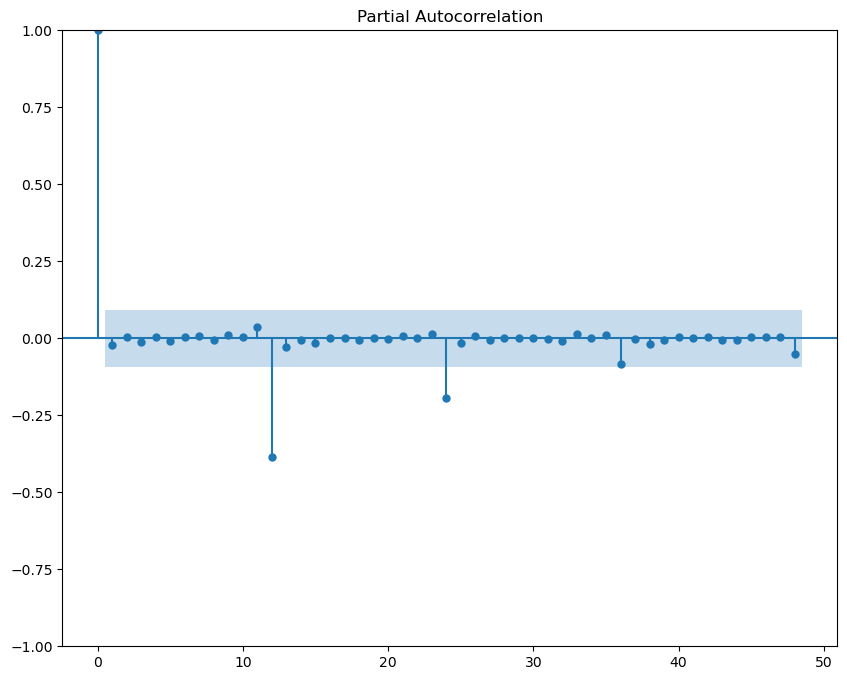

In [35]:
plot_acf(arima_1.resid,lags=48)
plt.show()
plot_pacf(arima_1.resid,lags=48,method='ywm')
plt.show()

Los residuos para este se ven bastante bien, solamente tenemos algunos picos en el PACF que son lo estacional; veamos la evaluación de este modelo:

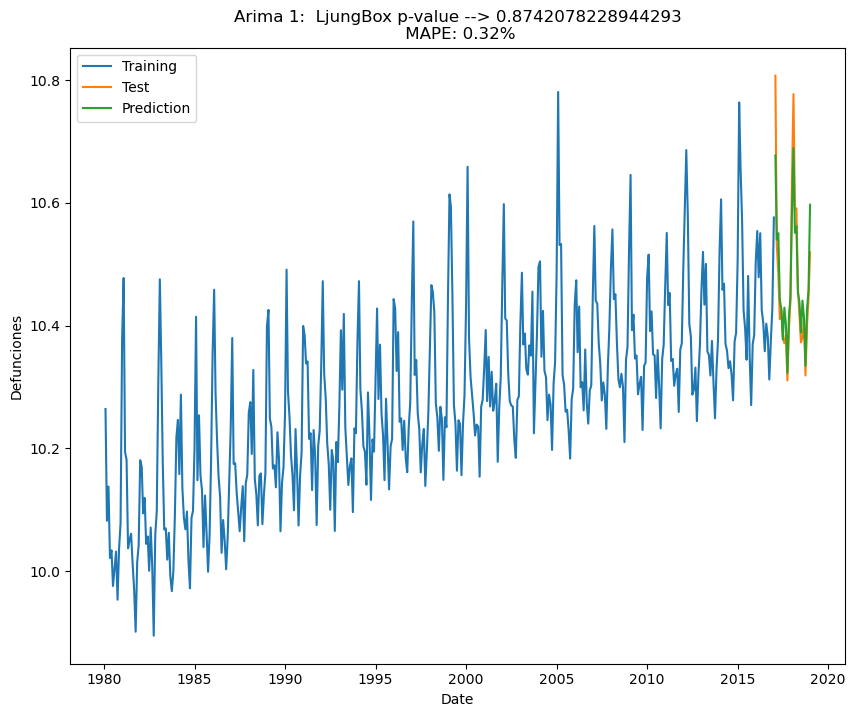

0.8742078228944293


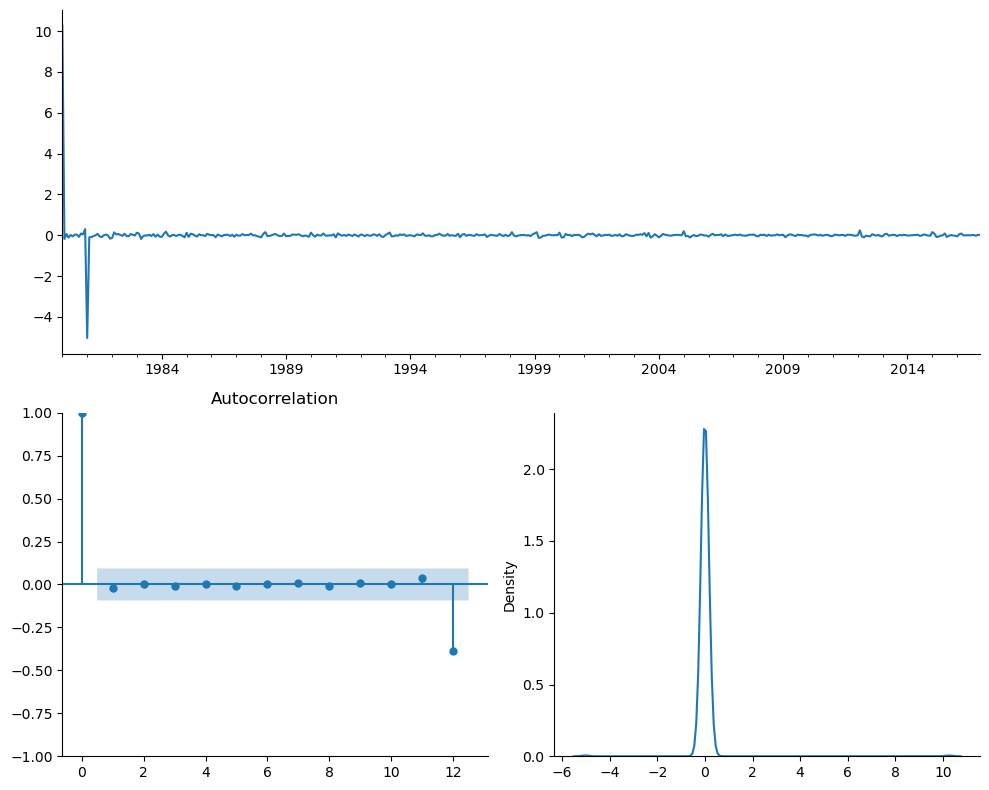

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.874 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [36]:
eval_model(arima_1,defun_tr1,defun_tst1,'Arima 1')

residcheck(arima_1.resid,12)

Tenemos buenos resultados! Estamos pasando el test de Ljung-Box y el de AD Fuller, no así el de normalidad, y el error está bastante bien. 

Veamos el siguiente modelo

##### Modelo 2 -> Con AR en lo regular y MA en ambas partes:

In [37]:
arima2 = SARIMAX(defun_tr1, 
                order = (1, 1, 1), 
                seasonal_order =(0, 1, 1, 12))
  
arima_2 = arima2.fit()
arima_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                   Todas las causas   No. Observations:                  444
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 715.057
Date:                            Sun, 19 Feb 2023   AIC                          -1422.114
Time:                                    12:19:56   BIC                          -1405.849
Sample:                                01-31-1980   HQIC                         -1415.692
                                     - 12-31-2016                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4575      0.042     10.885      0.000       0.375       0.540
ma.L1         -0.9748      0.020    -49.335      0.000      -1.014      -0.936
ma.S.L12      -0.9863      0.129     -7.668      0.000      -1.238      -0.734
sigma2         0.0019      0.000      8.065      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               326.96
Prob(Q):                              0.85   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.00
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

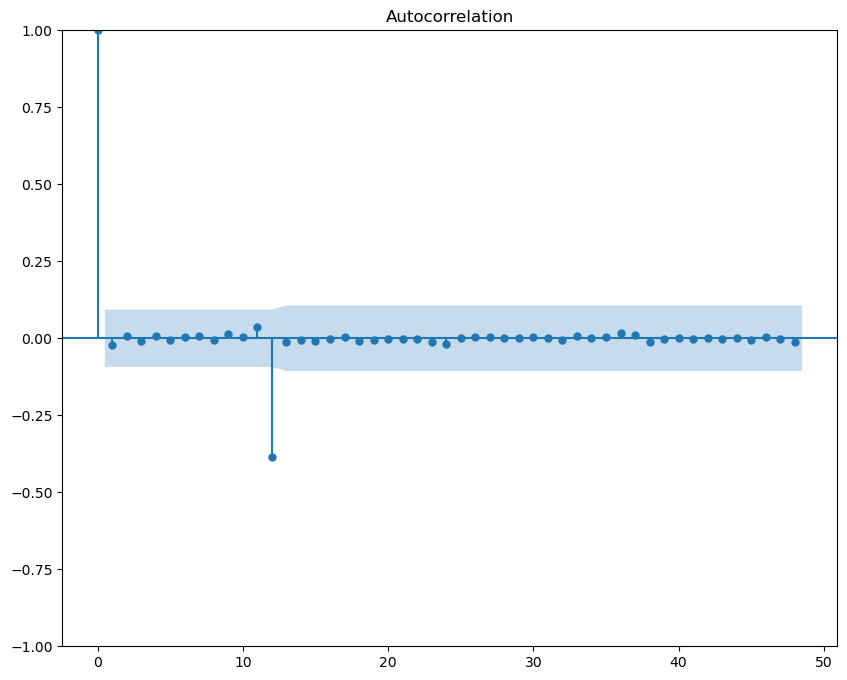

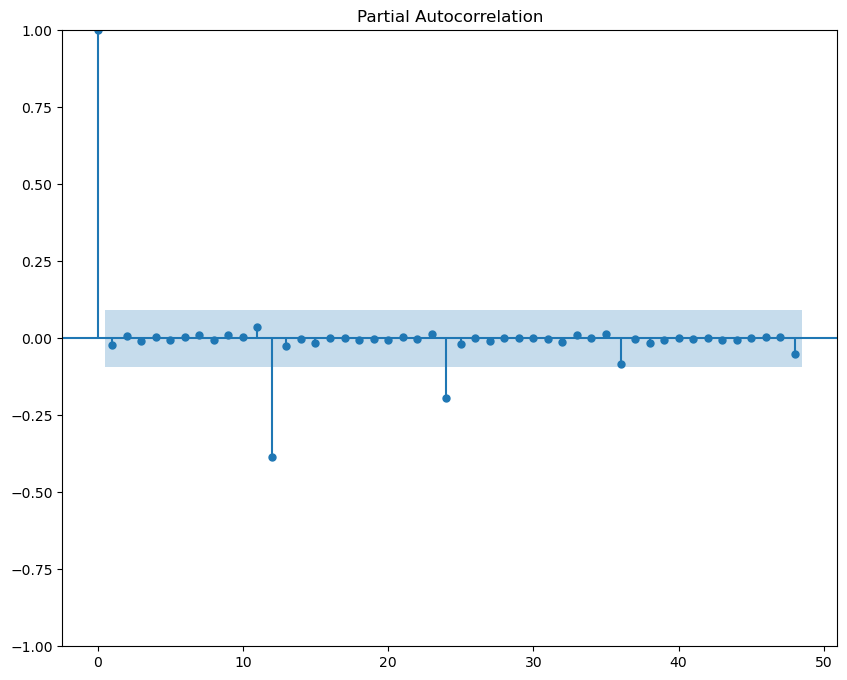

In [38]:
plot_acf(arima_2.resid,lags=48)
plt.show()
plot_pacf(arima_2.resid,lags=48,method='ywm')
plt.show()

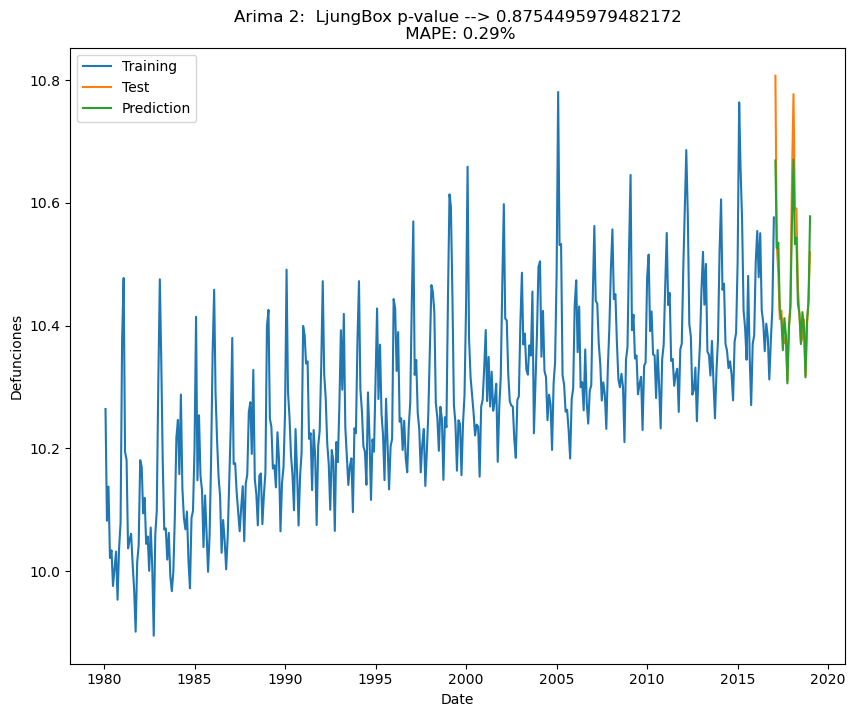

0.8754495979482172


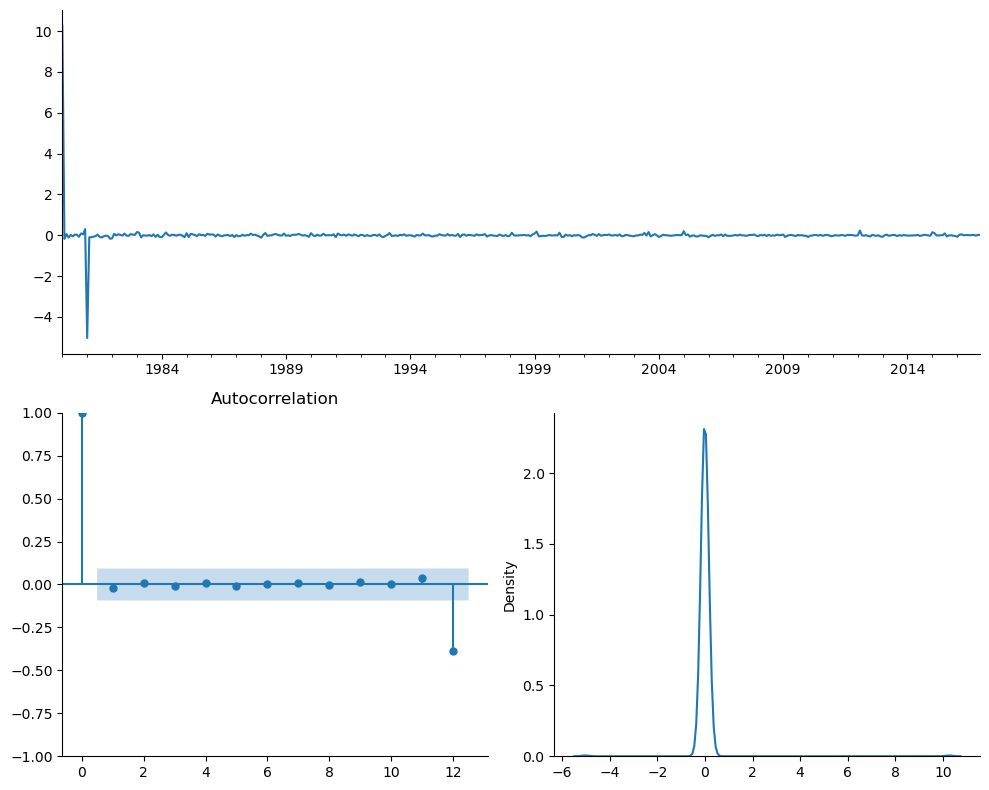

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.875 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [39]:
eval_model(arima_2,defun_tr1,defun_tst1,'Arima 2')

residcheck(arima_2.resid,12)

Tenemos de nuevo buenos resultados, de hecho muy similares a los anteriores pero en este caso mejora levemente el MAPE lo cual es bueno. Estamos pasando el test de Ljung-Box (con prácticamente el mismo p-value) y el de AD Fuller, no así el de normalidad (aunque la forma de la campana se ve bastante bien, lo que pasa es que tenemos una cola a la derecha con frecuencias minúsculas pero muy alargada), y el error está bastante bien. Veamos el siguiente modelo

##### Modelo 3 -> Con AR en lo regular y MA en ambas partes, con orden 2 en lo regular

In [40]:
arima3 = SARIMAX(defun_tr1, 
                order = (1, 1, 2), 
                seasonal_order =(0, 1, 1, 12))
  
arima_3 = arima3.fit()
arima_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                     Todas las causas   No. Observations:                  444
Model:             SARIMAX(1, 1, 2)x(0, 1, [1], 12)   Log Likelihood                 715.294
Date:                              Sun, 19 Feb 2023   AIC                          -1420.587
Time:                                      12:20:00   BIC                          -1400.257
Sample:                                  01-31-1980   HQIC                         -1412.560
                                       - 12-31-2016                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3978      0.101      3.919      0.000       0.199       0.597
ma.L1         -0.8999      0.110     -8.172      0.000      -1.116      -0.684
ma.L2         -0.0718      0.102     -0.703      0.482      -0.272       0.128
ma.S.L12      -0.9860      0.126     -7.805      0.000      -1.234      -0.738
sigma2         0.0019      0.000      8.180      0.000       0.001       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               329.20
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.78   Skew:                             1.01
Prob(H) (two-sided):                  0.14   Kurtosis:                         6.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

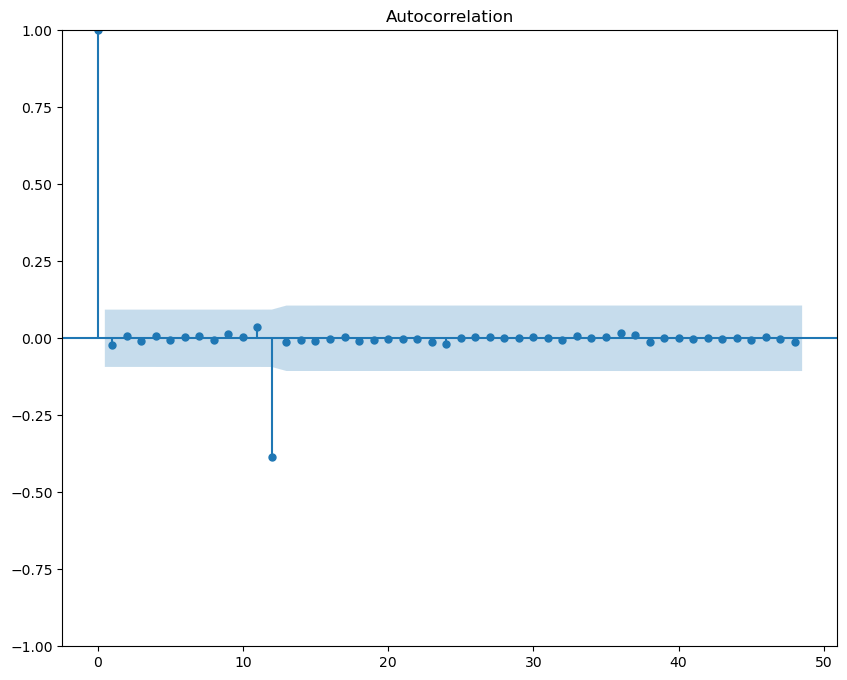

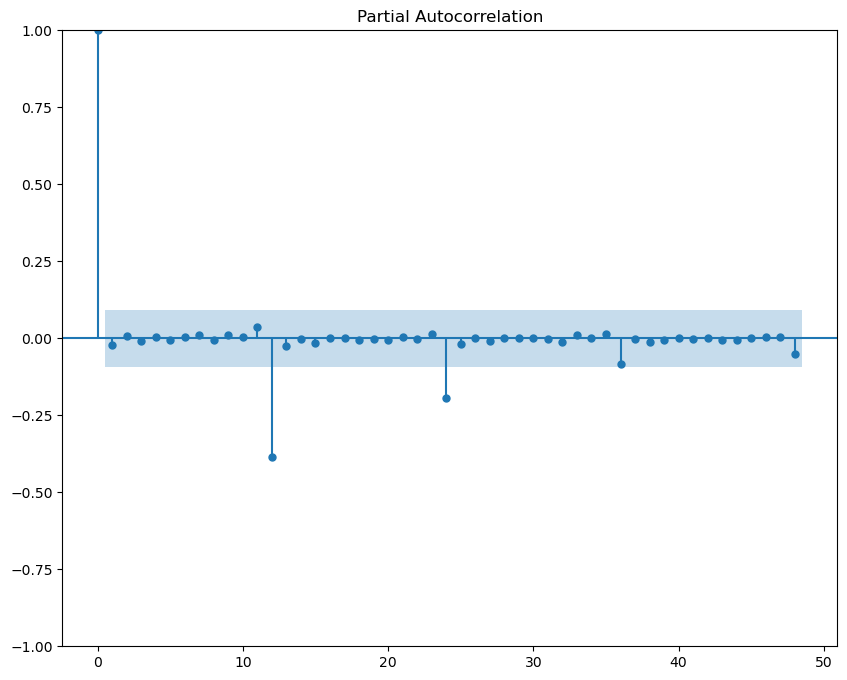

In [41]:
plot_acf(arima_3.resid,lags=48)
plt.show()
plot_pacf(arima_3.resid,lags=48,method='ywm')
plt.show()

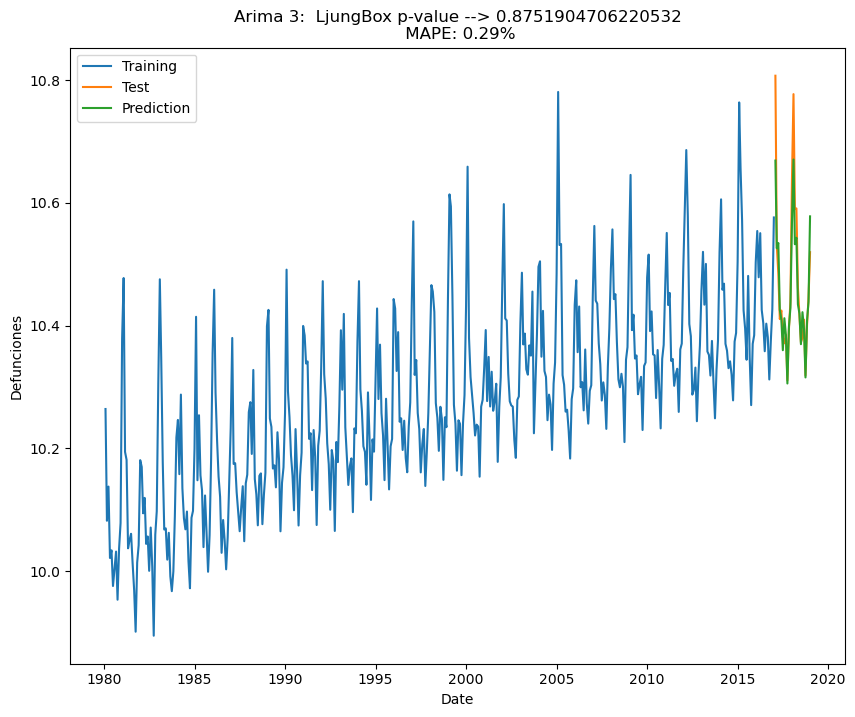

0.8751904706220532


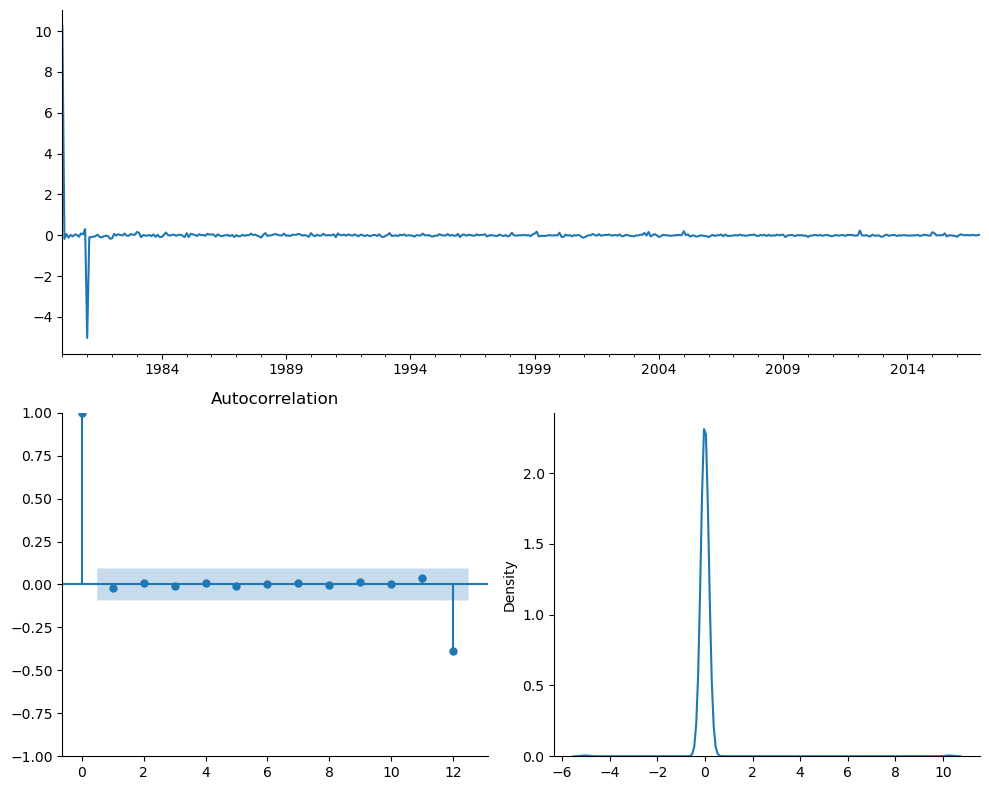

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.875 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [42]:
eval_model(arima_3,defun_tr1,defun_tst1,'Arima 3')

residcheck(arima_3.resid,12)

Buen modelo, de hecho es practicamente igual al anterior y si vemos el summary del modelo, el p-value de MA L2, es alto, lo que nos indica que MA en el orden 2 no es significativo, nos quedaremos con el modelo 2 (aunque analizaremos luego el RSME tanto para el 1 como para el 2 a ver si algo cambia en la decisión).

**Nota:** se probaron estos mismos modelos en el "backlog" con la serie al natural y si bien es cierto, si pasaban el test de Ljung  Box, de nuevo tenemos mucha diferencia en el MAPE y además en este caso tenemos también residuos con mucha más correlación, con varios puntos significativos en ACM y PACF; hicimos bien en trabajar la serie con transformación logarítmica.

### AutoARIMA

In [43]:
import pmdarima as pm

arima_auto1 = pm.auto_arima(defun_tr1, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=12,
                      d=None,              #Dejemos al modelo determinar el valor de d
                      seasonal=True,
                      #start_P=None,
                      D=None,              #Dejemos al modelo determinar el valor de D
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto1.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-1236.639, Time=2.24 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-424.481, Time=0.12 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-1187.603, Time=1.73 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-904.066, Time=0.53 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=3331.164, Time=0.05 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-1006.923, Time=1.87 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-1185.527, Time=1.35 sec
 ARIMA(1,0,1)(2,0,1)[12] intercept   : AIC=-1276.373, Time=3.63 sec
 ARIMA(1,0,1)(2,0,0)[12] intercept   : AIC=-1281.935, Time=3.06 sec
 ARIMA(0,0,1)(2,0,0)[12] intercept   : AIC=-799.764, Time=2.04 sec
 ARIMA(1,0,0)(2,0,0)[12] intercept   : AIC=inf, Time=2.83 sec
 ARIMA(2,0,1)(2,0,0)[12] intercept   : AIC=-1263.231, Time=3.78 sec
 ARIMA(1,0,2)(2,0,0)[12] intercept   : AIC=-1279.663, Time=3.58 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=-1094.502, Time=2.55 sec
 ARIMA(0,0,2)(2

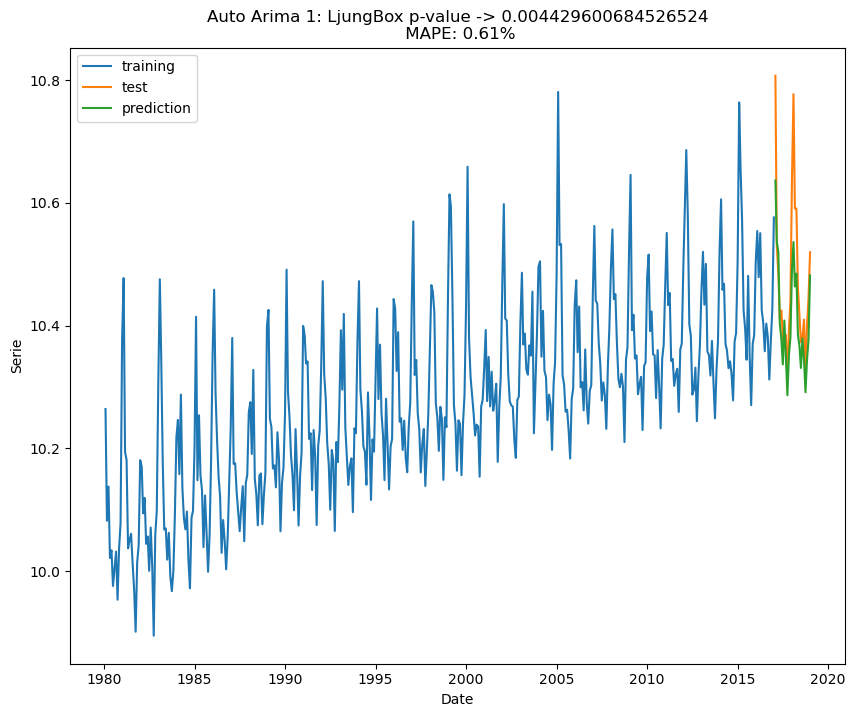

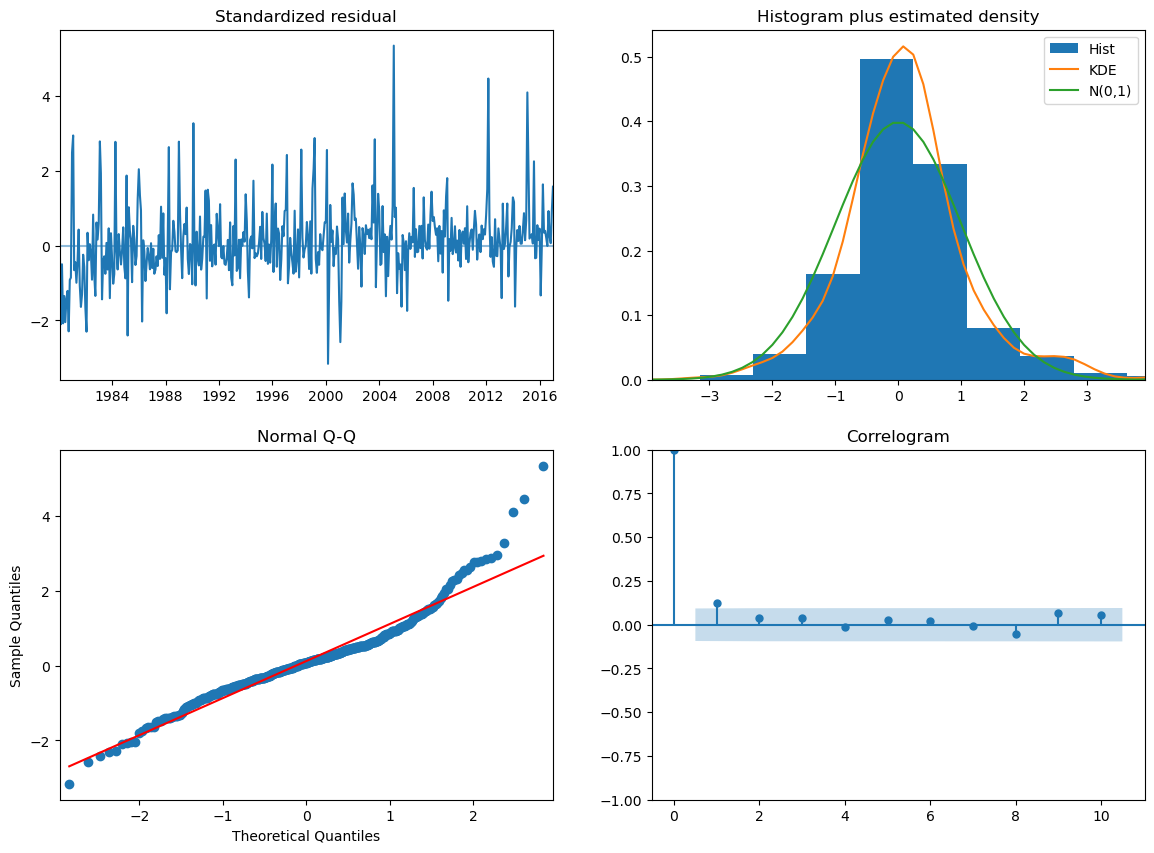

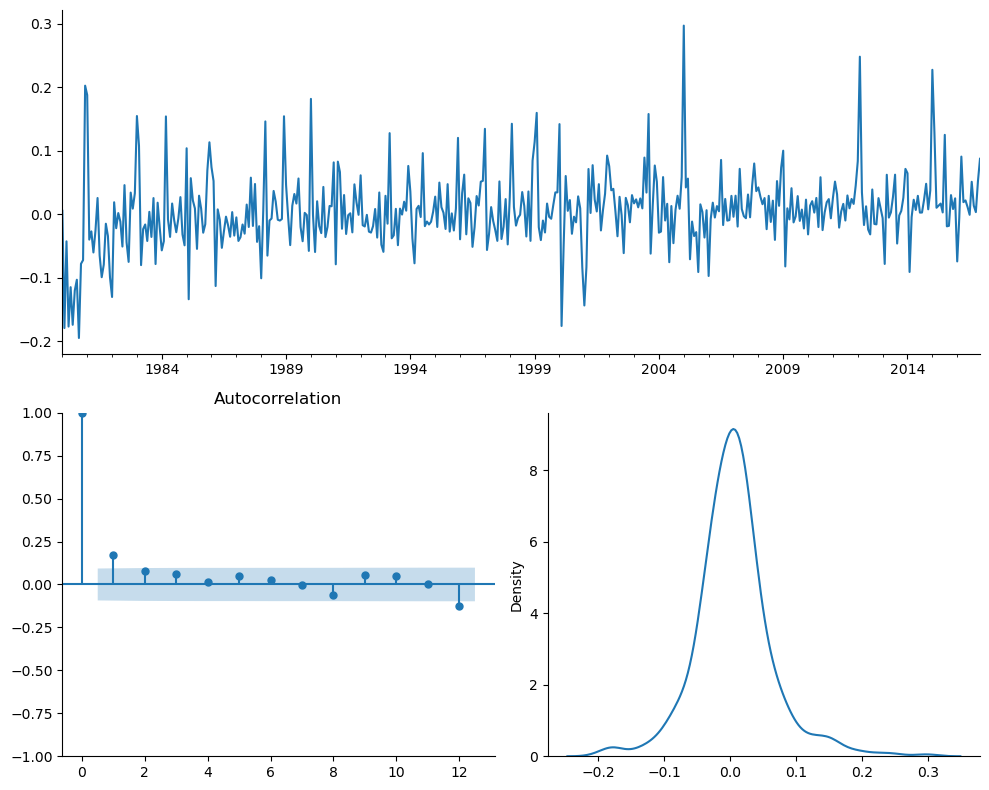

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.004 (<0.05, Correlated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.001 (<0.05, Stationary)


(<AxesSubplot:>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [44]:
eval_model_Aarima(arima_auto1,defun_tr1,defun_tst1,'Auto Arima 1')
residcheck(arima_auto1.resid(),12)

No están muy alentadores los resultados de este Auto Arima, el error es relativamente bajo, pero no está pasando el test de Ljung Box y efectivamente vemos residuos significativamente autocorrelacionados en el gráfico; vamos a indicarle explicitamente que el valor de d y D debe ser 1 para ver si logramos mejorar

In [45]:
arima_auto2 = pm.auto_arima(defun_tr1, start_p=1, start_q=1,
                      test='adf',
                      max_p=5, max_q=5,
                      m=12,
                      d=1,
                      seasonal=True,
                      #start_P=None,
                      D=1, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(arima_auto2.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=inf, Time=1.55 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=-999.880, Time=0.12 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=-1184.909, Time=0.41 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=1.72 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=-1021.723, Time=0.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=-1254.325, Time=1.01 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=4.14 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=inf, Time=2.15 sec
 ARIMA(0,1,0)(2,1,0)[12]             : AIC=-1221.712, Time=0.39 sec
 ARIMA(2,1,0)(2,1,0)[12]             : AIC=-1275.899, Time=1.37 sec
 ARIMA(2,1,0)(1,1,0)[12]             : AIC=-1203.544, Time=0.54 sec
 ARIMA(2,1,0)(2,1,1)[12]             : AIC=inf, Time=3.96 sec
 ARIMA(2,1,0)(1,1,1)[12]             : AIC=inf, Time=3.02 sec
 ARIMA(3,1,0)(2,1,0)[12]             : AIC=-1285.875, Time=1.70 sec
 ARIMA(3,1,0)(1,1,0)[12]             : AIC

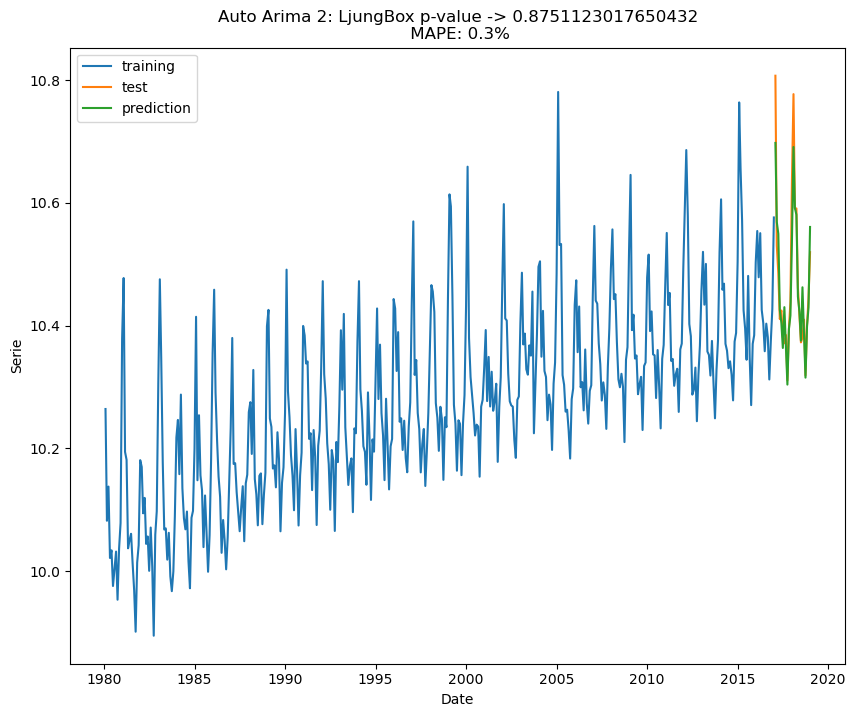

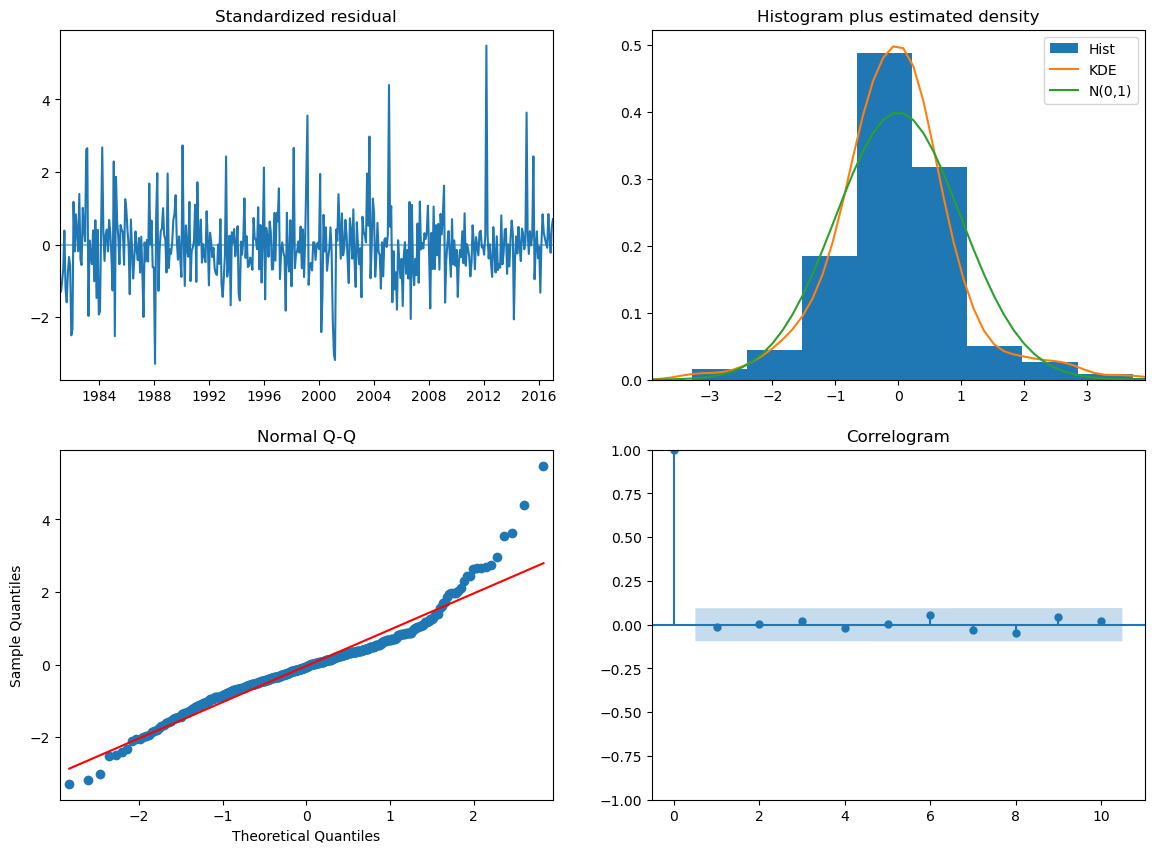

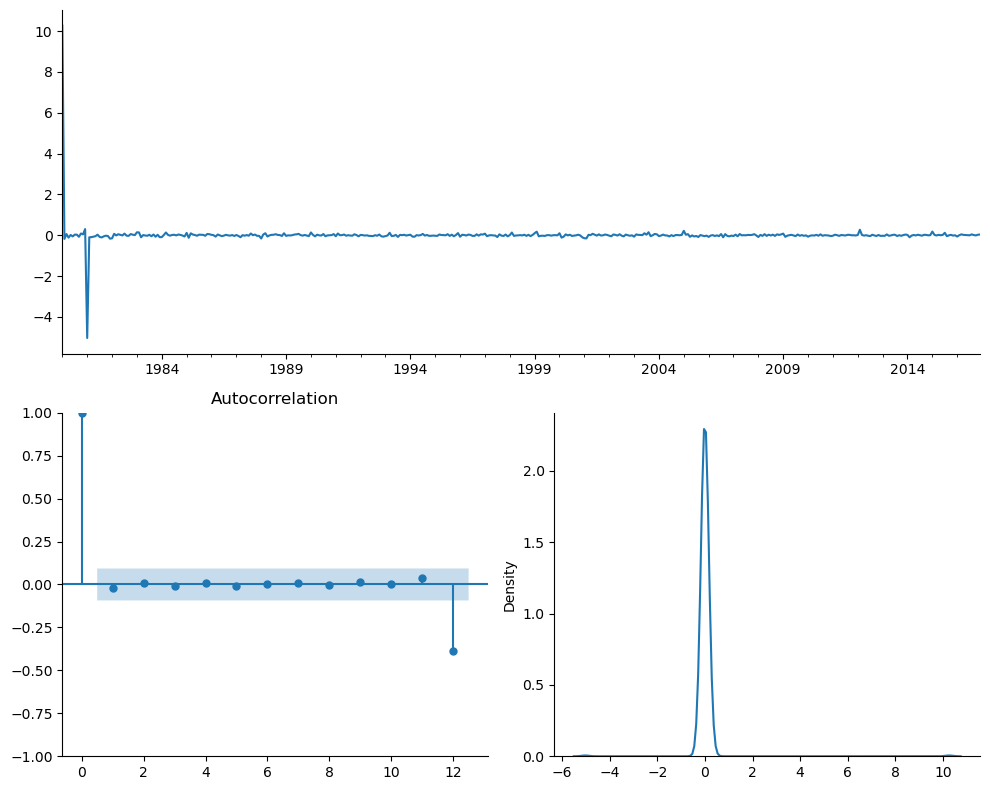

** Mean of the residuals:  0.01

** Ljung Box Test, p-value: 0.875 (>0.05, Uncorrelated)

** Jarque Bera Normality Test, p_value: 0.0 (<0.05, Not-normal)

** AD Fuller, p_value: 0.0 (<0.05, Stationary)


(<AxesSubplot:>,
 <AxesSubplot:title={'center':'Autocorrelation'}>,
 <AxesSubplot:ylabel='Density'>)

In [46]:
eval_model_Aarima(arima_auto2,defun_tr1,defun_tst1,'Auto Arima 2')
residcheck(arima_auto2.resid(),12)

Efectivamente tenemos una mejora considerable en el test de Ljung Box, el cual ahora si tiene un valor mayor a 0.05 y el error es de 0.3%, muy muy similar a lo que obtuvimos en el ARIMA manual. Vamos a hacer ahora la comparación de RMSE de los modelos que hemos seleccionado como buenas opciones para escoger uno. 

### Comparación. En relación al RMSE en el conjunto de tets, ¿Qué modelo resulta más preciso en sus predicciones?

In [47]:
from math import sqrt

predicted1 = hw_mul1.forecast(steps=len(defun_tst1))
RMSE1 = round(sqrt(mean_squared_error(defun_tst1, predicted1)),3)

predicted2 = hw_add1.forecast(steps=len(defun_tst1))
RMSE2 = round(sqrt(mean_squared_error(defun_tst1, predicted2)),3)

predicted3 = arima_1.forecast(steps=len(defun_tst1))
RMSE3 = round(sqrt(mean_squared_error(defun_tst1, predicted3)),3)

predicted4 = arima_2.forecast(steps=len(defun_tst1))
RMSE4 = round(sqrt(mean_squared_error(defun_tst1, predicted4)),3)

predicted5 = arima_auto2.predict(n_periods=len(defun_tst1))
RMSE5 = round(sqrt(mean_squared_error(defun_tst1, predicted5)),3)

RMSE = pd.DataFrame({'Modelo': ['HW Multi', 'HW Aditivo', 'ARIMA 1', 'ARIMA 2', 'Auto ARIMA'],
                   'RSME': [RMSE1, RMSE2, RMSE3, RMSE4, RMSE5]})
RMSE

Modelo   RSME
0    HW Multi  0.045
1  HW Aditivo  0.046
2     ARIMA 1  0.046
3     ARIMA 2  0.047
4  Auto ARIMA  0.045

Con base en estos resultados, el auto Arima y el HW Multi son los mejores, sin embargo recordemos que los modelos suavizados no pasaban el test de Ljung Box, vamos a ver todos los resultados generales para estos modelos además del RSME:

In [48]:
modelos = [hw_mul1, hw_add1, arima_1, arima_2, arima_auto2]
results = []

for model in modelos:
    if model == arima_auto2:
        pred = model.predict(n_periods=len(defun_tst1))
        lb1 = round(np.mean(sm.stats.acorr_ljungbox(model.resid(), lags=12, return_df=True).lb_pvalue),4)
    else:
        pred = model.forecast(steps=len(defun_tst1))
        lb1 = round(np.mean(sm.stats.acorr_ljungbox(model.resid, lags=12, return_df=True).lb_pvalue),4)
    MAPE = round(mean_absolute_percentage_error(defun_tst1, pred)*100,2)
    RMSE = round(sqrt(mean_squared_error(defun_tst1, pred))*100,3)
    results.append({'Model': model.__class__.__name__, 'Ljung-Box Test p-value': lb1, 'MAPE': MAPE, 'RMSE': RMSE})
    
comparacion = pd.DataFrame(results)
comparacion


Model  Ljung-Box Test p-value  MAPE   RMSE
0  HoltWintersResultsWrapper                  0.0002  0.29  4.478
1  HoltWintersResultsWrapper                  0.0002  0.30  4.575
2      SARIMAXResultsWrapper                  0.8742  0.32  4.607
3      SARIMAXResultsWrapper                  0.8754  0.29  4.665
4                      ARIMA                  0.8751  0.30  4.537

Entonces, como es lógico, descartamos los modelos de Holt Winters por su resultado de Ljung-Box, y realmente tenemos mucha similitud en todos los resultados de ARIMA, pero si queremos basarnos en el RMSE, por una pequeña diferencia elegimos el Auto Arima:

**Best model:  ARIMA(2,1,1)(2,1,0)[12]**